# Notebook ML : Prédiction de la Date de Fin de Menace, Clustering Thématique et Alertes Email

Ce notebook intègre :
- Un modèle supervisé pour l’imputation des valeurs manquantes, en particulier la date de fin de menace (`finalerte`).
- Un modèle non supervisé pour le regroupement thématique des vulnérabilités.
- Un système d’alerte email pour notifier les vulnérabilités critiques détectées.

## 1. Importation des Librairies

On importe les librairies nécessaires pour la manipulation des données, le machine learning, la visualisation et l’envoi d’emails.

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import datetime

import smtplib
from email.mime.text import MIMEText

import warnings
warnings.filterwarnings('ignore')

## 2. Chargement et Préparation des Données

On charge le fichier CSV enrichi, on convertit les dates, on affiche les colonnes, on encode les variables catégorielles, et on identifie les valeurs manquantes (notamment la date de fin de menace).

In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Charger les données enrichies
df = pd.read_csv(r'c:\Users\aitnd\Documents\GitHub\Alertes-ANSSI\data\cve_cleaned_for_df.csv')

# Afficher les colonnes et un aperçu
print("Colonnes du CSV :", list(df.columns))
print(df.head(2))

# Conversion des dates
df['Publiée le'] = pd.to_datetime(df['Publiée le'], errors='coerce')
df["Date de fin d'alerte"] = pd.to_datetime(df["Date de fin d'alerte"], errors='coerce')

# Encodage des variables catégorielles principales
cat_cols = ['Base Severity', 'ID CWE', 'Vendeur', 'Type (Avis ou Alerte)']
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown').astype(str)

# Encodage label pour les variables catégorielles (pour ML)
label_encoders = {}
for col in cat_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col+'_enc'] = le.fit_transform(df[col])
        label_encoders[col] = le

# Conversion des scores en numérique
df['Score CVSS'] = df['Score CVSS'].replace(['Pas de Score CVSS', 'Non disponible', ''], np.nan)
df['Score CVSS'] = pd.to_numeric(df['Score CVSS'], errors='coerce')

df['Score EPSS'] = df['Score EPSS'].replace(['Pas de Score EPSS', 'Non disponible', ''], np.nan)
df['Score EPSS'] = pd.to_numeric(df['Score EPSS'], errors='coerce')

# Affichage des valeurs manquantes
print("\nValeurs manquantes par colonne :")
print(df.isnull().sum())

# Focus sur la colonne cible pour la prédiction supervisée
print("\nExemples de valeurs de \"Date de fin d'alerte\" :")
print(df["Date de fin d'alerte"].head(10))

Colonnes du CSV : ['Identifiant ANSSI', 'Titre', 'Type (Avis ou Alerte)', 'Publiée le', "Date de fin d'alerte", 'ID CVE', 'Score CVSS', 'Base Severity', 'Score EPSS', 'ID CWE', 'Description CWE', 'Lien', 'Description', 'Vendeur', 'Produit', 'Version Affectés', 'Différence en jours']
     Identifiant ANSSI                                              Titre Type (Avis ou Alerte)                 Publiée le       Date de fin d'alerte          ID CVE Score CVSS Base Severity  Score EPSS          ID CWE Description CWE                                               Lien                                        Description    Vendeur         Produit                                   Version Affectés Différence en jours
0  CERTFR-2022-ALE-007  Multiples vulnérabilités dans Microsoft Window...                alerte  2022-09-16 00:00:00+00:00  2023-03-14 00:00:00+00:00  CVE-2022-34718        9.8      CRITICAL     0.84306  Non disponible  Non disponible  https://www.cert.ssi.gouv.fr/alerte/CERTFR-20

# 3. Vizualisation des données

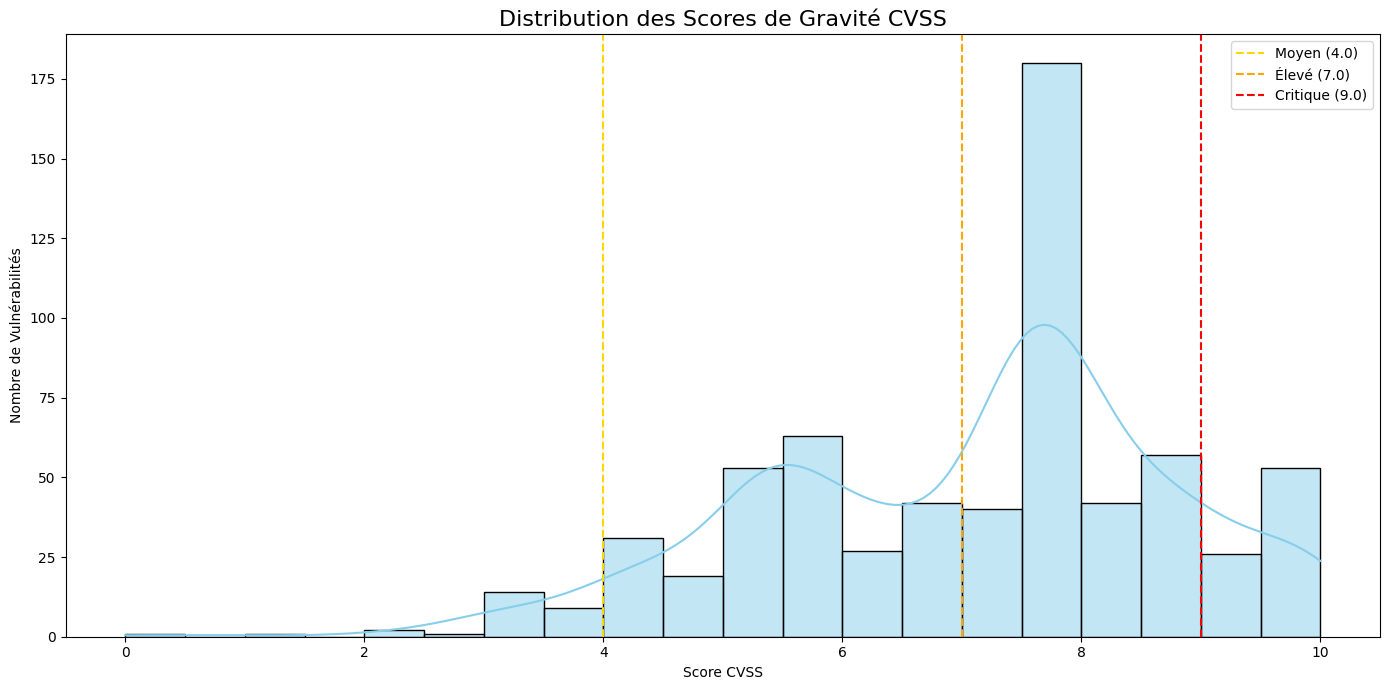

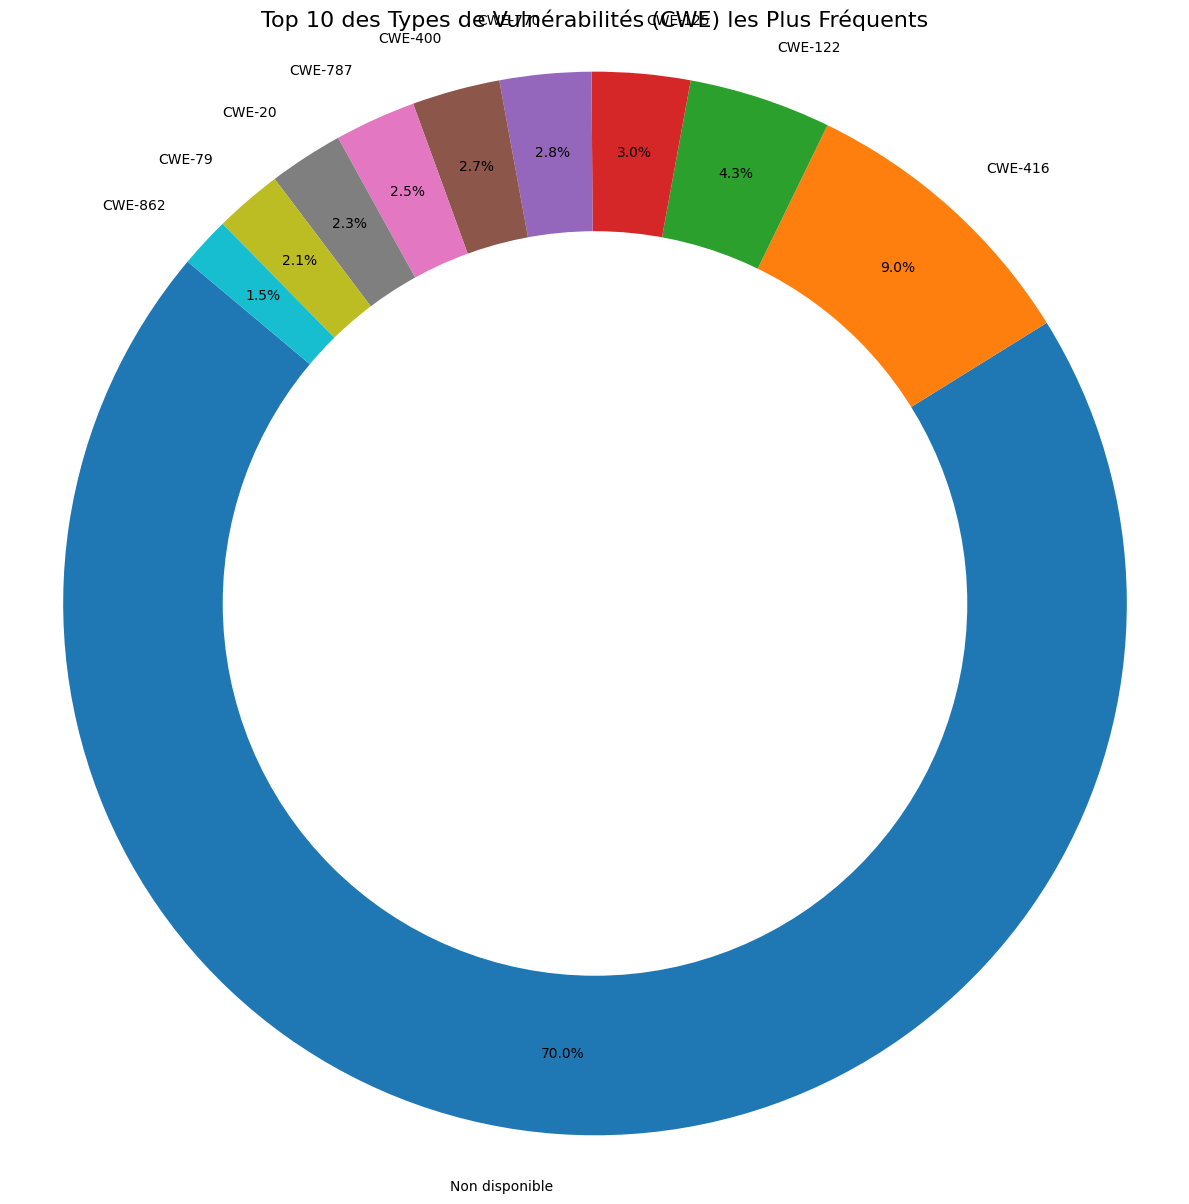

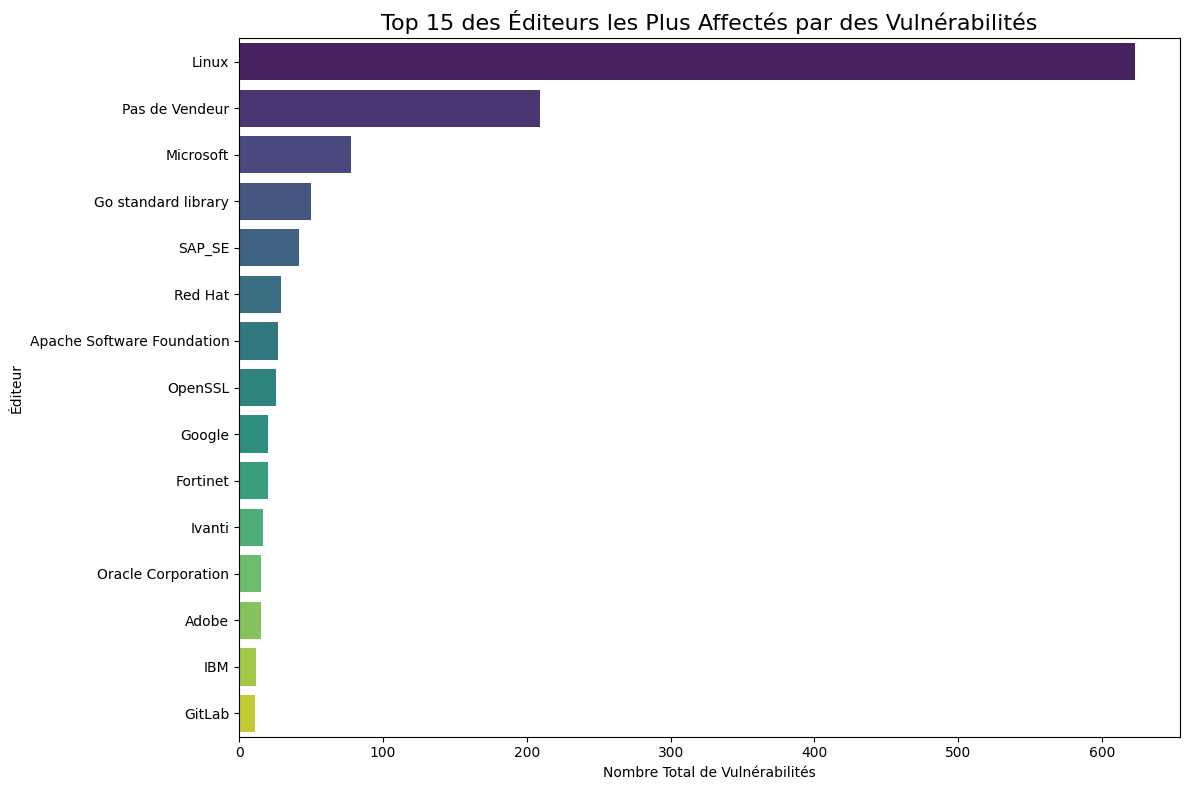

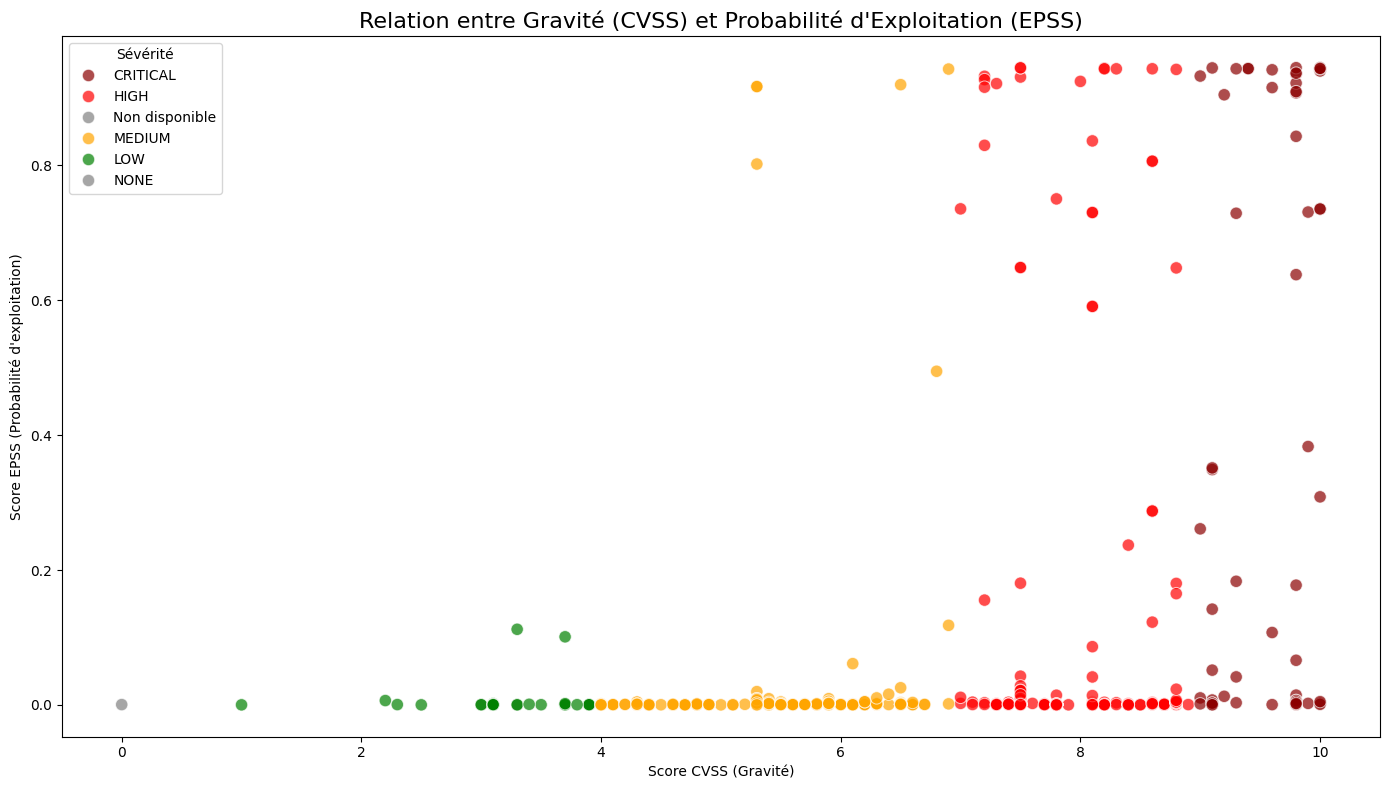

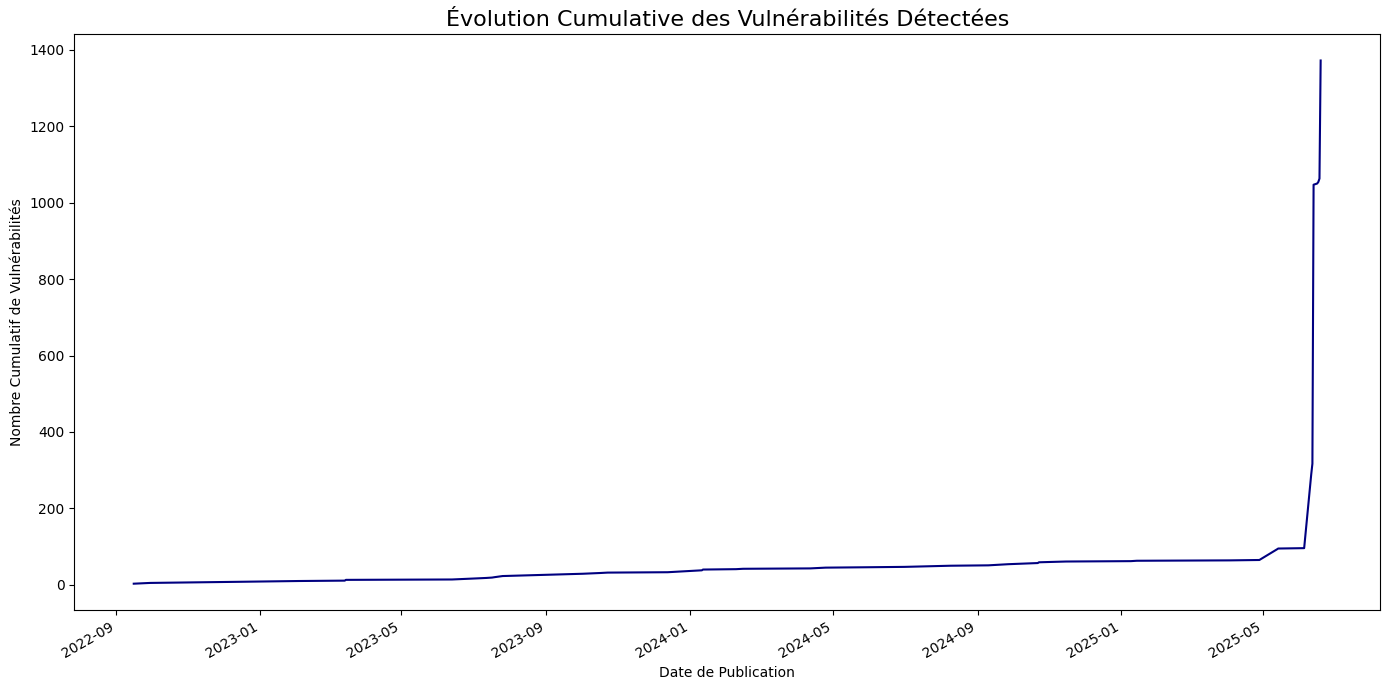

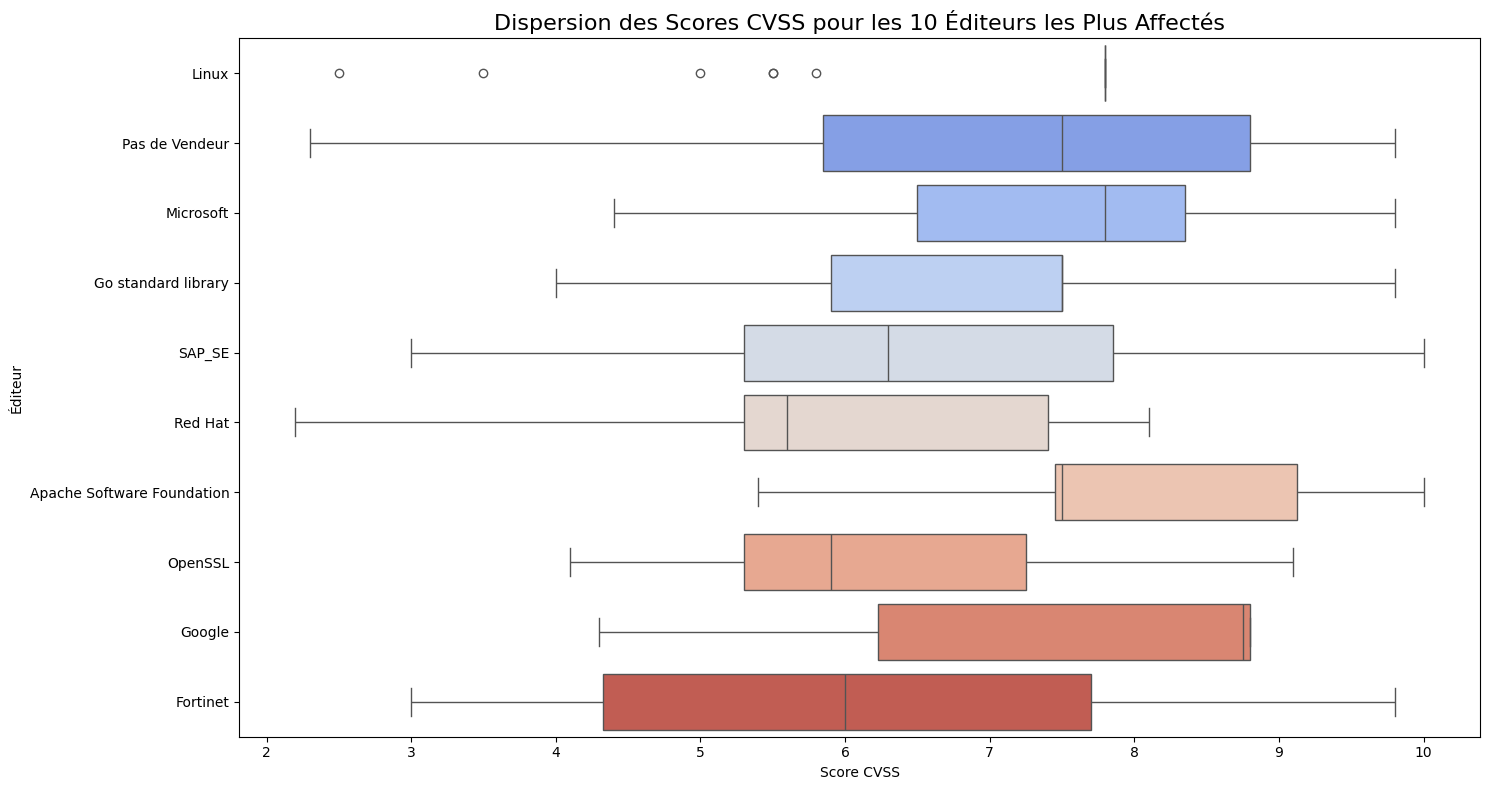

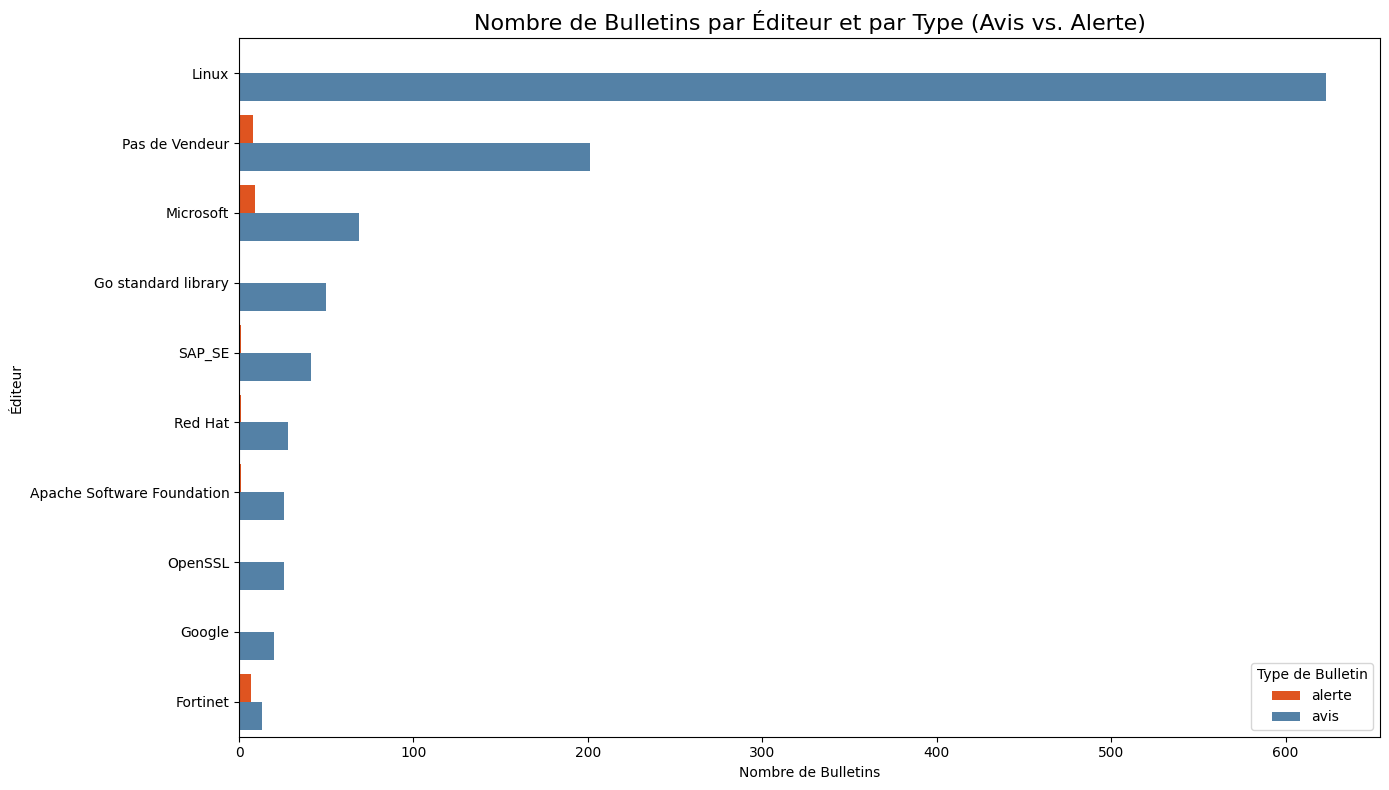

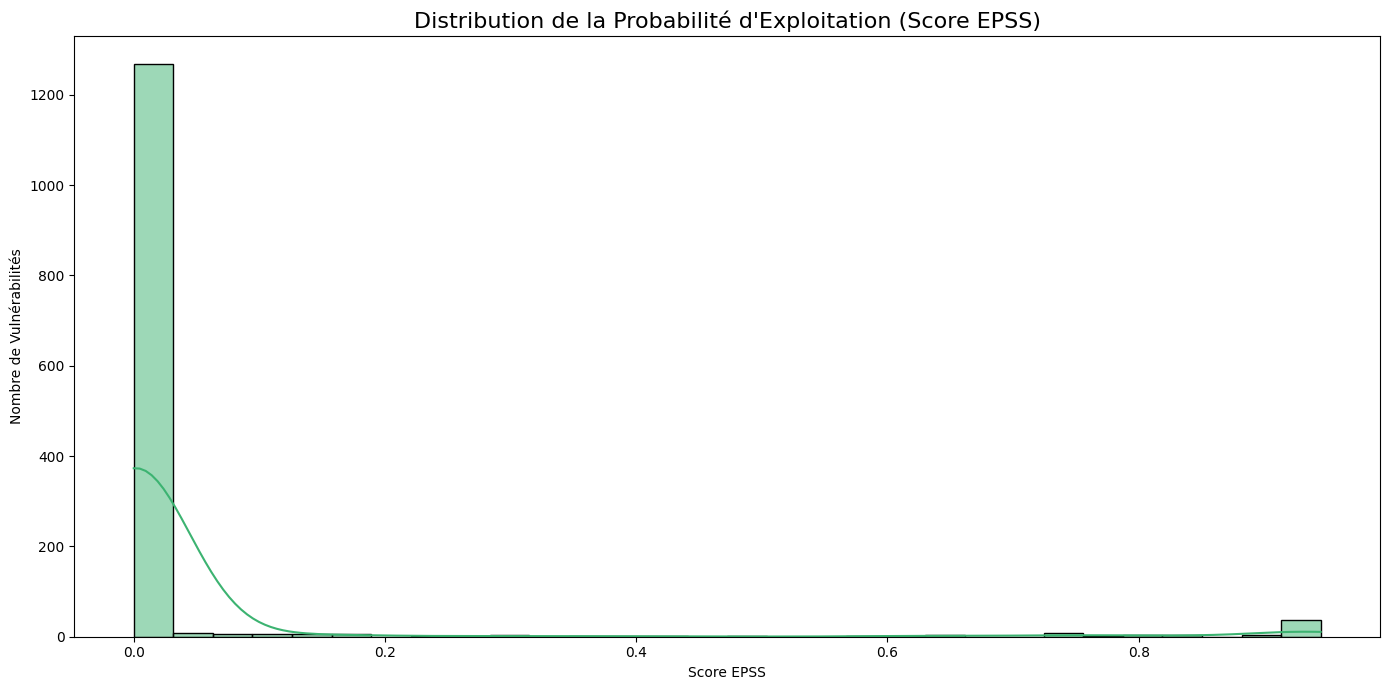

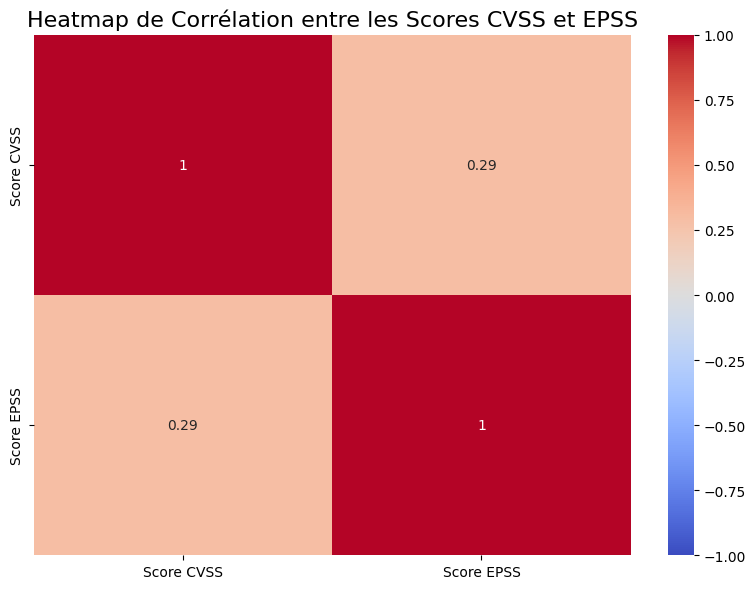

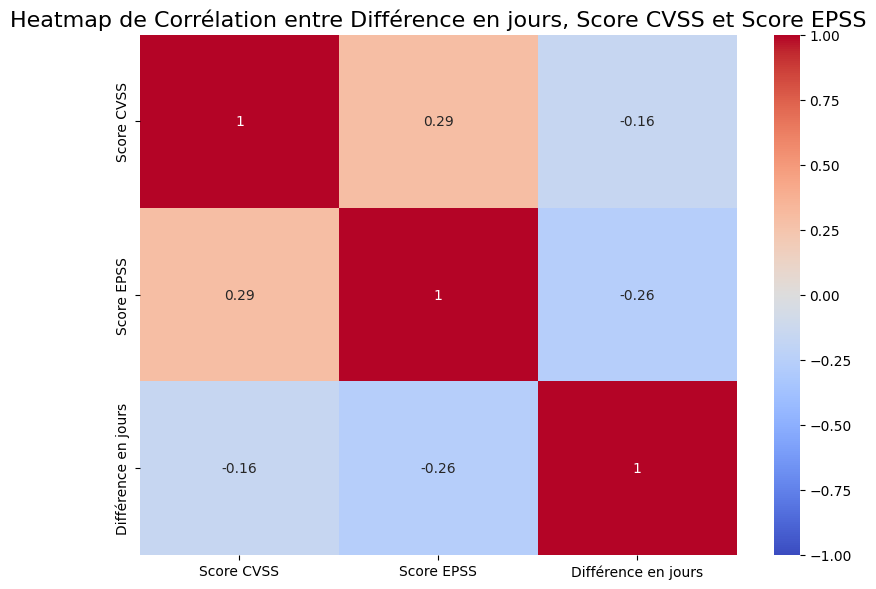

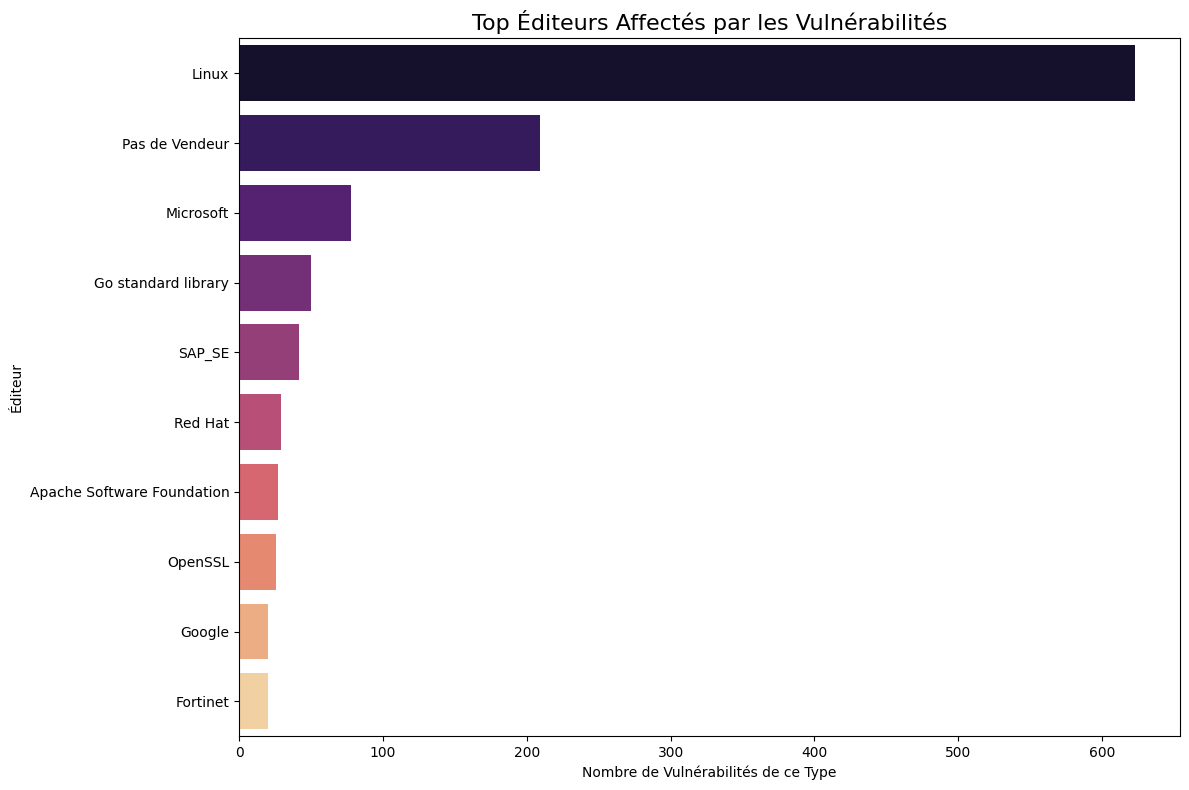

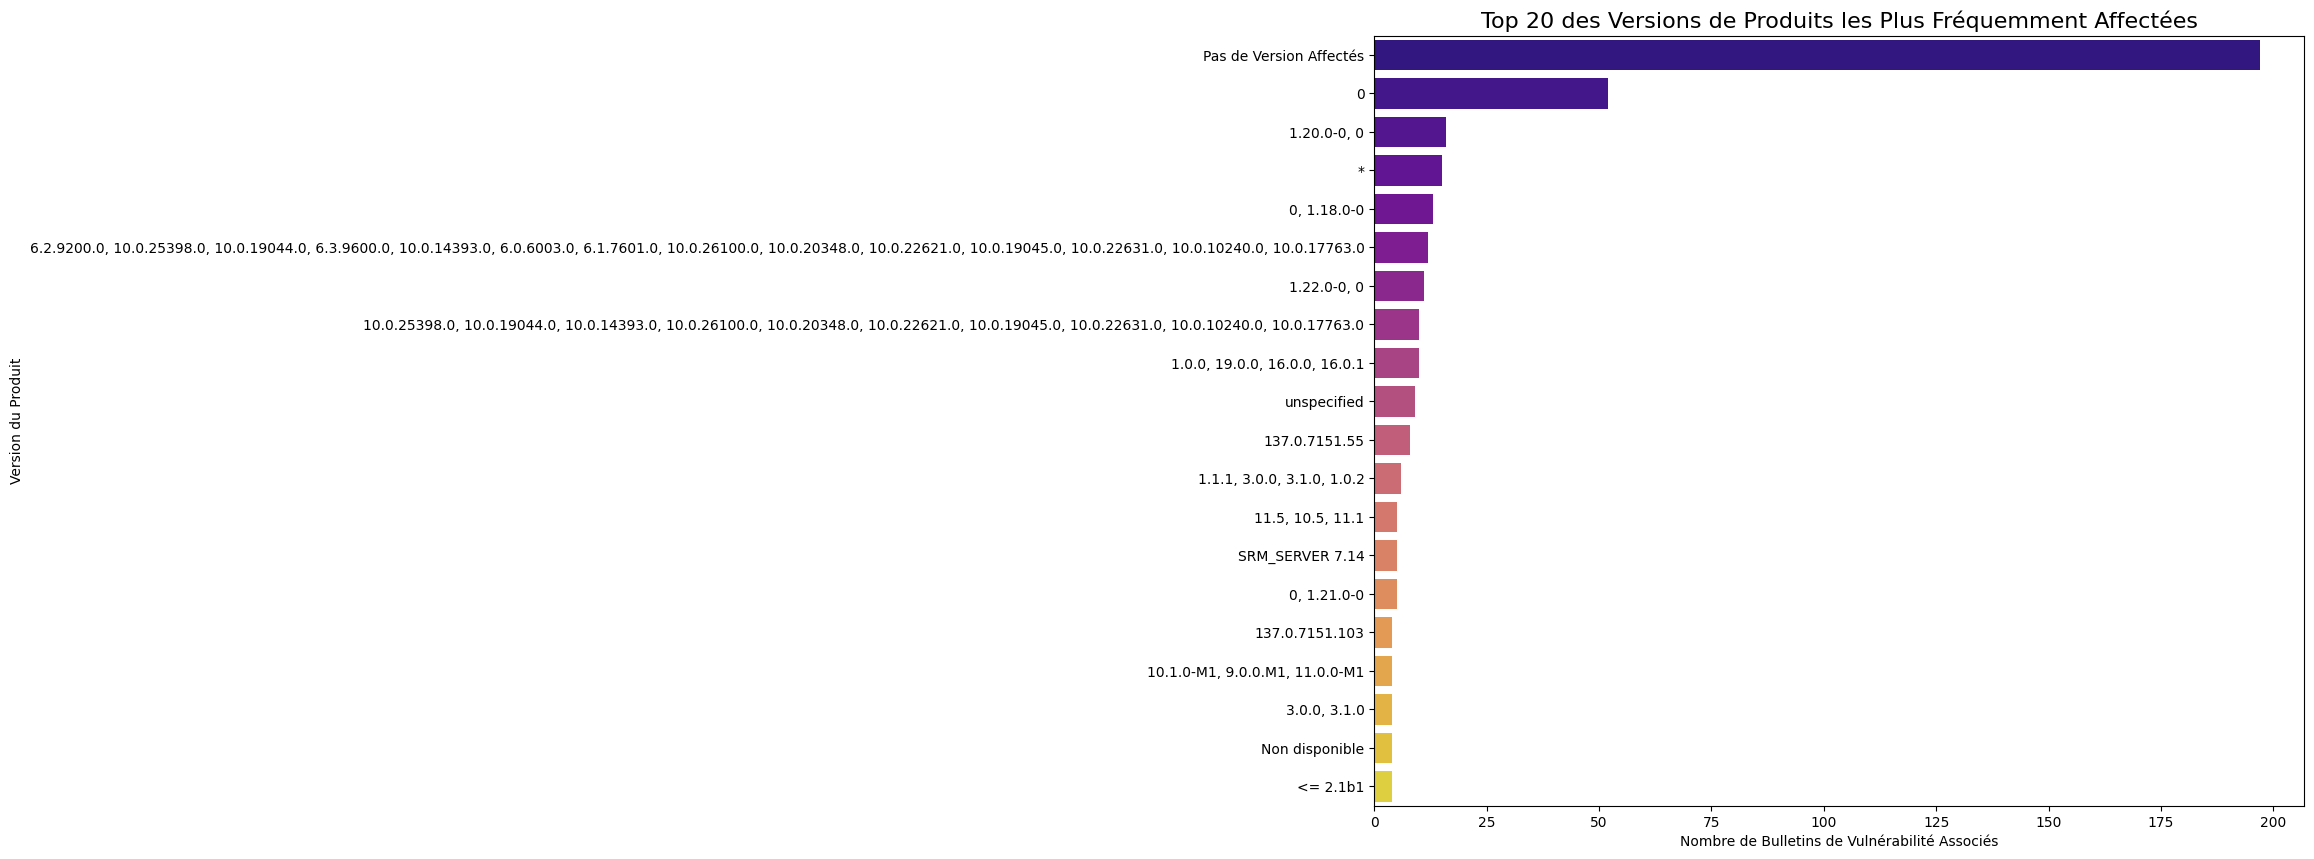

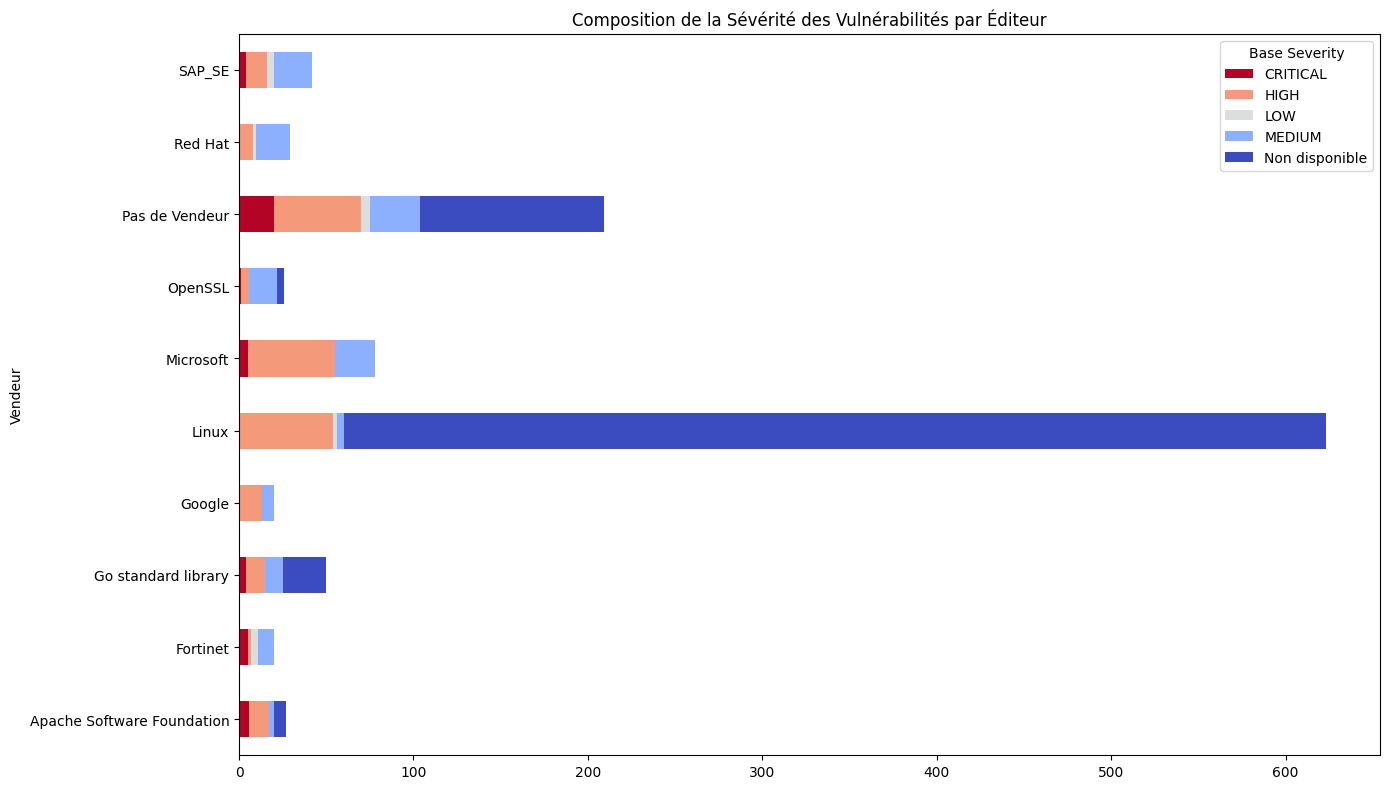

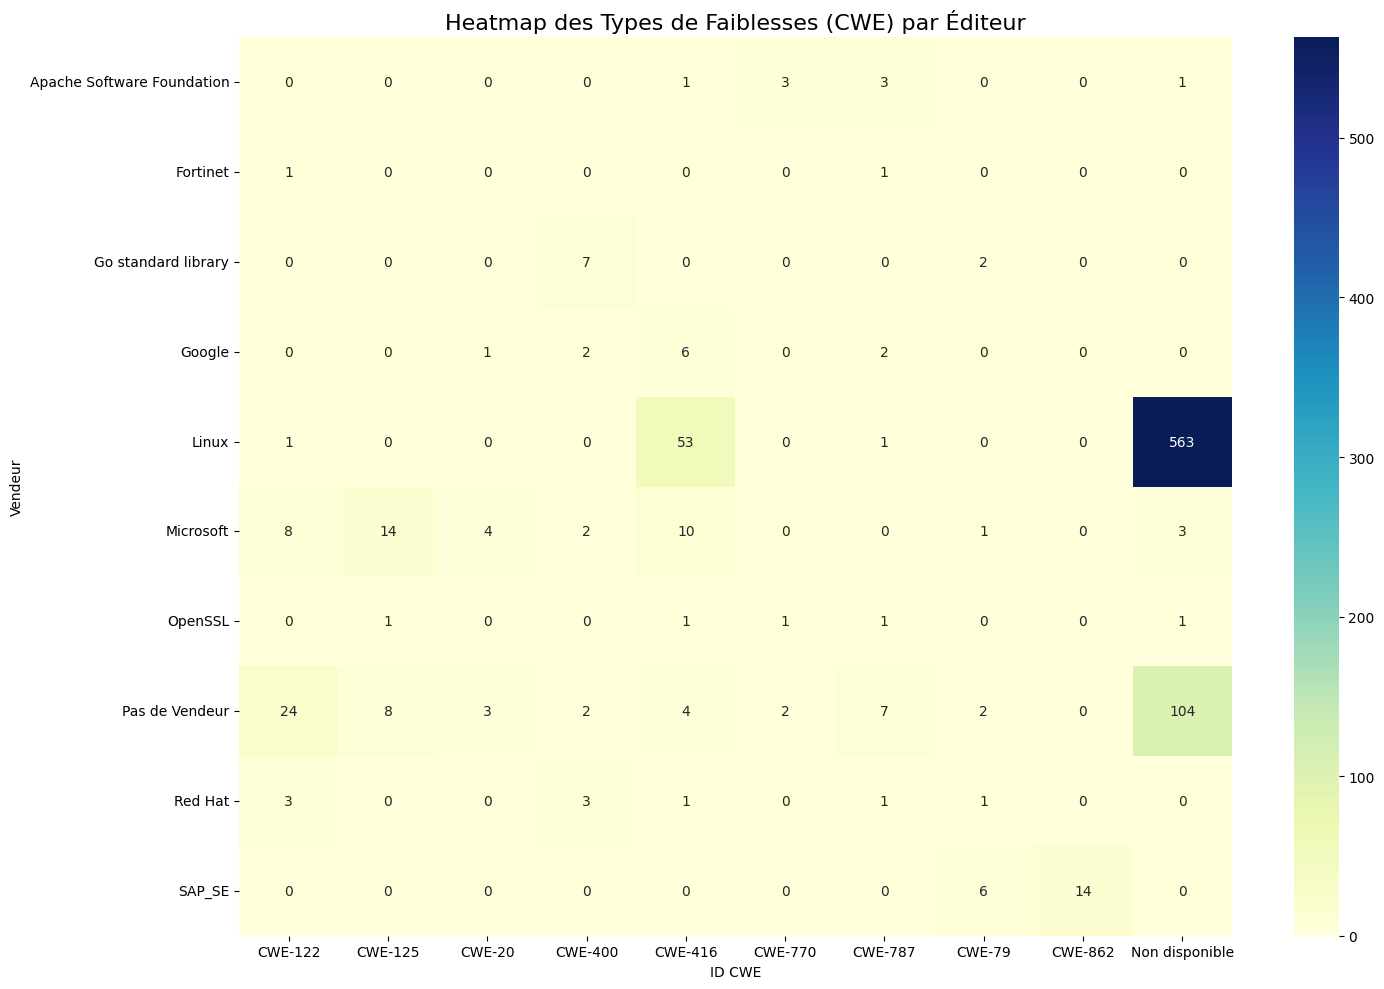

In [35]:
# Créer le dossier si nécessaire
os.makedirs("diagrams", exist_ok=True)

# Configuration de l'affichage
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

# Lecture et renommage des colonnes
df = pd.read_csv("../data/cve_cleaned_for_df.csv")
df = df[[
    "Identifiant ANSSI",
    "Titre",
    "Type (Avis ou Alerte)",
    "Publiée le",
    "Date de fin d'alerte",
    "ID CVE",
    "Score CVSS",
    "Base Severity",
    "Score EPSS",
    "ID CWE",
    "Description CWE",
    "Lien",
    "Description",
    "Vendeur",
    "Produit",
    "Version Affectés",
    "Différence en jours"
]]  

# Fonctions de nettoyage pour les colonnes sous forme de string
def clean_vendor(vendor_str):
    if isinstance(vendor_str, str):
        vendors = [v.strip() for v in vendor_str.split(",")]
        unique_vendors = set(vendors)
        return ", ".join(unique_vendors)
    return vendor_str

def clean_versions(versions_str):
    if isinstance(versions_str, str):
        versions = [v.strip() for v in versions_str.split(",")]
        unique_versions = set(versions)
        return ", ".join(unique_versions)
    return versions_str

df["Vendeur"] = df["Vendeur"].apply(clean_vendor)
df["Version Affectés"] = df["Version Affectés"].apply(clean_versions)

# Conversion des scores en numérique si nécessaire
df["Score CVSS"] = pd.to_numeric(df["Score CVSS"], errors="coerce")
df["Score EPSS"] = pd.to_numeric(df["Score EPSS"], errors="coerce")

# Conversion de la date de publication en datetime
df["Publiée le"] = pd.to_datetime(df["Publiée le"], errors="coerce")

# ---------------------------
# 1. Histogramme des Scores CVSS
plt.figure(figsize=(14, 7))
sns.histplot(df['Score CVSS'], bins=20, kde=True, color='skyblue')
plt.axvline(x=4.0, color='gold', linestyle='--', label='Moyen (4.0)')
plt.axvline(x=7.0, color='orange', linestyle='--', label='Élevé (7.0)')
plt.axvline(x=9.0, color='red', linestyle='--', label='Critique (9.0)')
plt.title('Distribution des Scores de Gravité CVSS', fontsize=16)
plt.xlabel('Score CVSS')
plt.ylabel('Nombre de Vulnérabilités')
plt.legend()
plt.tight_layout()
plt.savefig("diagrams/histogram_cvss.png", dpi=300)
plt.show()

# ---------------------------
# 2. Diagramme circulaire (Donut) pour le Top 10 des CWE
top_cwe = df['ID CWE'].value_counts().nlargest(10)
plt.figure(figsize=(12, 12))
plt.pie(top_cwe, labels=top_cwe.index, autopct='%1.1f%%', startangle=140, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Top 10 des Types de Vulnérabilités (CWE) les Plus Fréquents', fontsize=16)
plt.axis('equal')
plt.tight_layout()
plt.savefig("diagrams/donut_top_cwe.png", dpi=300)
plt.show()

# ---------------------------
# 3. Diagramme à barres pour le Top 15 des éditeurs (Vendeur)
plt.figure(figsize=(12, 8))
top_vendors = df['Vendeur'].value_counts().nlargest(15)
sns.barplot(x=top_vendors.values, y=top_vendors.index, palette='viridis')
plt.title('Top 15 des Éditeurs les Plus Affectés par des Vulnérabilités', fontsize=16)
plt.xlabel('Nombre Total de Vulnérabilités')
plt.ylabel('Éditeur')
plt.tight_layout()
plt.savefig("diagrams/bar_top_vendors.png", dpi=300)
plt.show()

# ---------------------------
# 4. Scatter plot : Score CVSS vs Score EPSS

# Palette dynamique pour toutes les valeurs de sévérité présentes
unique_sev = df['Base Severity'].unique()
default_palette = {
    'Non disponible': 'grey',
    'LOW': 'green',
    'MEDIUM': 'orange',
    'HIGH': 'red',
    'CRITICAL': 'darkred',
    'NONE': 'grey',
    'None': 'grey',
    'none': 'grey'
}
palette = {sev: default_palette.get(sev, 'grey') for sev in unique_sev}

plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=df,
    x='Score CVSS',
    y='Score EPSS',
    hue='Base Severity',
    palette=palette,
    alpha=0.7,
    s=80
)
plt.title('Relation entre Gravité (CVSS) et Probabilité d\'Exploitation (EPSS)', fontsize=16)
plt.xlabel('Score CVSS (Gravité)')
plt.ylabel('Score EPSS (Probabilité d\'exploitation)')
plt.legend(title='Sévérité')
plt.tight_layout()
plt.savefig("diagrams/scatter_cvss_epss.png", dpi=300)
plt.show()

# ---------------------------
# 5. Courbe cumulative des Vulnérabilités au fil du Temps
df_sorted_by_date = df.sort_values(by='Publiée le')
cumulative_vulns = df_sorted_by_date.groupby('Publiée le').size().cumsum()
plt.figure(figsize=(14, 7))
cumulative_vulns.plot(kind='line', color='navy')
plt.title('Évolution Cumulative des Vulnérabilités Détectées', fontsize=16)
plt.xlabel('Date de Publication')
plt.ylabel('Nombre Cumulatif de Vulnérabilités')
plt.tight_layout()
plt.savefig("diagrams/cumulative_vulns.png", dpi=300)
plt.show()

# ---------------------------
# 6. Boxplot des Scores CVSS pour les 10 Éditeurs les Plus Affectés
top_10_vendors_names = df['Vendeur'].value_counts().nlargest(10).index
df_top_vendors = df[df['Vendeur'].isin(top_10_vendors_names)]
plt.figure(figsize=(15, 8))
sns.boxplot(
    data=df_top_vendors,
    x='Score CVSS',
    y='Vendeur',
    order=top_10_vendors_names,
    palette='coolwarm'
)
plt.title('Dispersion des Scores CVSS pour les 10 Éditeurs les Plus Affectés', fontsize=16)
plt.xlabel('Score CVSS')
plt.ylabel('Éditeur')
plt.tight_layout()
plt.savefig("diagrams/boxplot_top_vendors_cvss.png", dpi=300)
plt.show()

# ---------------------------
# 7. Countplot du nombre de Bulletins par Éditeur et par Type (Avis vs. Alerte)
top_10_vendors_names = df['Vendeur'].value_counts().nlargest(10).index
df_top_vendors_types = df[df['Vendeur'].isin(top_10_vendors_names)]
plt.figure(figsize=(14, 8))
sns.countplot(
    data=df_top_vendors_types,
    y='Vendeur',
    hue='Type (Avis ou Alerte)',
    order=top_10_vendors_names,
    palette={'avis': 'steelblue', 'alerte': 'orangered'}
)
plt.title('Nombre de Bulletins par Éditeur et par Type (Avis vs. Alerte)', fontsize=16)
plt.xlabel('Nombre de Bulletins')
plt.ylabel('Éditeur')
plt.legend(title='Type de Bulletin')
plt.tight_layout()
plt.savefig("diagrams/countplot_vendors_bulletins.png", dpi=300)
plt.show()

# ---------------------------
# 8. Histogramme des Scores EPSS
plt.figure(figsize=(14, 7))
sns.histplot(df['Score EPSS'].dropna(), kde=True, color='mediumseagreen', bins=30)
plt.title("Distribution de la Probabilité d'Exploitation (Score EPSS)", fontsize=16)
plt.xlabel("Score EPSS")
plt.ylabel("Nombre de Vulnérabilités")
plt.tight_layout()
plt.savefig("diagrams/histogram_epss.png", dpi=300)
plt.show()

# ---------------------------
# 9. Heatmap de Corrélation entre Score CVSS et Score EPSS
correlation_matrix = df[['Score CVSS', 'Score EPSS']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    vmin=-1, vmax=1
)
plt.title('Heatmap de Corrélation entre les Scores CVSS et EPSS', fontsize=16)
plt.tight_layout()
plt.savefig("diagrams/heatmap_cvss_epss_corr.png", dpi=300)
plt.show()

# ---------------------------
# 9.1 analyse de la triple corrélation

# S'assurer que la colonne "Différence en jours" est bien en numérique
df["Différence en jours"] = pd.to_numeric(df["Différence en jours"], errors='coerce')

# Sélectionner les colonnes d'intérêt
cols = ["Score CVSS", "Score EPSS", "Différence en jours"]
corr_matrix = df[cols].corr()

# Afficher la heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Heatmap de Corrélation entre Différence en jours, Score CVSS et Score EPSS", fontsize=16)
plt.tight_layout()
plt.savefig("diagrams/heatmap_corr_diff_jours_cvss_epss.png", dpi=300)
plt.show()

# ---------------------------
# 10. Barplot des Top Éditeurs Affectés (pour analyse CWE)
top_vendors_for_cwe = df['Vendeur'].value_counts().nlargest(10)
plt.figure(figsize=(12, 8))
sns.barplot(x=top_vendors_for_cwe.values, y=top_vendors_for_cwe.index, palette='magma')
plt.title("Top Éditeurs Affectés par les Vulnérabilités", fontsize=16)
plt.xlabel("Nombre de Vulnérabilités de ce Type")
plt.ylabel("Éditeur")
plt.tight_layout()
plt.savefig("diagrams/bar_top_vendors_for_cwe.png", dpi=300)
plt.show()

# ---------------------------
# 11. Barplot des Top 20 Versions les Plus Fréquemment Affectées
top_versions = df['Version Affectés'].value_counts().nlargest(20)
plt.figure(figsize=(12, 10))
sns.barplot(x=top_versions.values, y=top_versions.index, palette='plasma')
plt.title('Top 20 des Versions de Produits les Plus Fréquemment Affectées', fontsize=16)
plt.xlabel('Nombre de Bulletins de Vulnérabilité Associés')
plt.ylabel('Version du Produit')
plt.tight_layout()
plt.savefig("diagrams/bar_top_product_versions.png", dpi=300)
plt.show()

# ---------------------------
# 12. Stacked Bar (Horizontal) : Composition de la Sévérité des Vulnérabilités par Éditeur
top_vendors_names = df['Vendeur'].value_counts().nlargest(10).index
df_top_vendors = df[df['Vendeur'].isin(top_vendors_names)]
severity_by_vendor = pd.crosstab(df_top_vendors['Vendeur'], df_top_vendors['Base Severity'])
severity_by_vendor.plot(kind='barh', stacked=True, figsize=(14, 8), colormap='coolwarm_r', title='Composition de la Sévérité des Vulnérabilités par Éditeur')
plt.tight_layout()
plt.savefig("diagrams/stacked_bar_severity_vendor.png", dpi=300)
plt.show()

# ---------------------------
# 13. Heatmap des Types de Faiblesses (CWE) par Éditeur
top_vendors = df['Vendeur'].value_counts().nlargest(10).index
top_cwes = df['ID CWE'].value_counts().nlargest(10).index
df_filtered = df[df['Vendeur'].isin(top_vendors) & df['ID CWE'].isin(top_cwes)]
cwe_vendor_matrix = pd.crosstab(df_filtered['Vendeur'], df_filtered['ID CWE'])
plt.figure(figsize=(15, 10))
sns.heatmap(cwe_vendor_matrix, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Heatmap des Types de Faiblesses (CWE) par Éditeur', fontsize=16)
plt.tight_layout()
plt.savefig("diagrams/heatmap_cwe_vendor_matrix.png", dpi=300)
plt.show()

## 4. Imputation Supervisée des Valeurs Manquantes (y compris la date de fin de menace)

On utilise un modèle supervisé (RandomForestRegressor) pour prédire les dates de fin de menace manquantes (`finalerte`).  
On encode la date en timestamp pour la régression, puis on réinjecte les valeurs prédites dans le DataFrame.

In [36]:
# 3. Imputation Supervisée Améliorée - Prédiction de la Durée au lieu de la Date
col_type = 'Type (Avis ou Alerte)'
col_id_anssi = 'Identifiant ANSSI'
col_datefin = "Date de fin d'alerte"

# Filtrer uniquement les alertes
df_alertes = df[df[col_type].str.lower() == 'alerte'].copy()

print(f"Nombre d'alertes trouvées : {len(df_alertes)}")

if len(df_alertes) > 0:
    # Conversion et nettoyage des scores numériques
    df_alertes['Score CVSS'] = df_alertes['Score CVSS'].replace(['Pas de Score CVSS', 'Non disponible', ''], np.nan)
    df_alertes['Score CVSS'] = pd.to_numeric(df_alertes['Score CVSS'], errors='coerce')
    
    df_alertes['Score EPSS'] = df_alertes['Score EPSS'].replace(['Pas de Score EPSS', 'Non disponible', ''], np.nan)
    df_alertes['Score EPSS'] = pd.to_numeric(df_alertes['Score EPSS'], errors='coerce')
    
    # Encodage des variables catégorielles
    for col in ['Base Severity', 'ID CWE', 'Vendeur', 'Type (Avis ou Alerte)']:
        enc_col = f"{col}_enc"
        if enc_col not in df_alertes.columns:
            le = LabelEncoder()
            df_alertes[enc_col] = le.fit_transform(df_alertes[col].astype(str))

    # Standardiser les timezones
    df_alertes['Publiée le'] = pd.to_datetime(df_alertes['Publiée le'], errors='coerce')
    df_alertes[col_datefin] = pd.to_datetime(df_alertes[col_datefin], errors='coerce')

    # **AMÉLIORATION CLÉS : Calculer la DURÉE en jours au lieu de prédire la date directement**
    valid_dates = df_alertes[col_datefin].notnull() & df_alertes['Publiée le'].notnull()
    
    # Calculer la durée en jours entre publication et fin d'alerte
    df_alertes['duree_alerte_jours'] = np.nan
    df_alertes.loc[valid_dates, 'duree_alerte_jours'] = (
        df_alertes.loc[valid_dates, col_datefin] - df_alertes.loc[valid_dates, 'Publiée le']
    ).dt.days
    
    # S'assurer que la durée est positive (contrainte métier)
    df_alertes.loc[df_alertes['duree_alerte_jours'] <= 0, 'duree_alerte_jours'] = 7  # Minimum 7 jours

    # Sélection des features explicatives
    features = [
        'Score CVSS', 'Score EPSS', 'Base Severity_enc', 'ID CWE_enc', 'Vendeur_enc', 'Type (Avis ou Alerte)_enc'
    ]

    # Gestion des valeurs manquantes dans les features
    for col in features:
        if col in df_alertes.columns and df_alertes[col].isnull().any():
            if df_alertes[col].dtype.kind in 'biufc':
                df_alertes[col].fillna(df_alertes[col].median(), inplace=True)
            else:
                df_alertes[col].fillna(-1, inplace=True)

    # Séparer train/pred basé sur la durée calculée
    df_train = df_alertes[df_alertes['duree_alerte_jours'].notnull()]
    df_pred = df_alertes[df_alertes['duree_alerte_jours'].isnull()]

    print(f"Alertes avec durée calculée : {len(df_train)}")
    print(f"Alertes sans durée (à prédire) : {len(df_pred)}")

    if len(df_train) >= 1 and not df_pred.empty:
        print("\n🔧 Application d'un modèle de prédiction de DURÉE (plus robuste)...")
        
        X_train = df_train[features]
        y_train = df_train['duree_alerte_jours']  # On prédit la DURÉE, pas la date
        X_pred = df_pred[features]

        # **Stratégie 1 : Règles métier pour la durée**
        def create_duration_based_predictions(df_pred):
            """Créer des prédictions de durée basées sur des règles métier"""
            durations = []
            
            for idx, row in df_pred.iterrows():
                # Règles basées sur la sévérité et le score CVSS
                severity = row['Base Severity']
                cvss_score = row['Score CVSS']
                
                if pd.isna(cvss_score):
                    cvss_score = 5.0  # valeur par défaut
                
                # Durée estimée selon la criticité (en jours)
                if severity == 'CRITICAL' or cvss_score >= 9.0:
                    duration_days = 30  # 1 mois pour critique
                elif severity == 'HIGH' or cvss_score >= 7.0:
                    duration_days = 60  # 2 mois pour élevé  
                elif severity == 'MEDIUM' or cvss_score >= 4.0:
                    duration_days = 90  # 3 mois pour moyen
                else:
                    duration_days = 120  # 4 mois pour bas
                
                # Ajuster selon le type de CWE (vulnérabilité)
                cwe_id = str(row['ID CWE'])
                if 'CWE-79' in cwe_id or 'CWE-89' in cwe_id:  # XSS, SQL Injection
                    duration_days = max(30, duration_days - 15)  # Plus urgent, mais minimum 30 jours
                elif 'CWE-200' in cwe_id:  # Information Disclosure
                    duration_days += 30  # Moins urgent
                
                # Contrainte : minimum 7 jours, maximum 365 jours
                duration_days = max(7, min(365, duration_days))
                durations.append(duration_days)
            
            return pd.Series(durations, index=df_pred.index)

        # **Stratégie 2 : Modèle ML pour prédire la durée**
        if len(df_train) >= 3:
            try:
                from sklearn.linear_model import Ridge
                from sklearn.ensemble import RandomForestRegressor
                
                # Standardisation
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_pred_scaled = scaler.transform(X_pred)

                # Modèle pour prédire la durée
                if len(df_train) < 10:
                    model = Ridge(alpha=1.0)
                else:
                    model = RandomForestRegressor(n_estimators=50, max_depth=3, random_state=42)
                
                model.fit(X_train_scaled, y_train)
                y_pred_duration_ml = model.predict(X_pred_scaled)
                
                # Contraintes sur les prédictions ML
                y_pred_duration_ml = np.clip(y_pred_duration_ml, 7, 365)  # Entre 7 et 365 jours
                
                # Prédictions basées sur les règles
                y_pred_duration_rules = create_duration_based_predictions(df_pred)
                
                # Combiner les deux approches (moyenne pondérée)
                weight_ml = min(len(df_train) / 10, 0.7)
                weight_rules = 1 - weight_ml
                
                y_pred_duration_combined = (weight_ml * y_pred_duration_ml + 
                                           weight_rules * y_pred_duration_rules.values)
                
                print(f"📊 Modèle hybride durée : {weight_ml:.2f} ML + {weight_rules:.2f} Règles")
                
            except Exception as e:
                print(f"⚠️ Erreur ML, utilisation des règles uniquement : {e}")
                y_pred_duration_combined = create_duration_based_predictions(df_pred).values
        else:
            # Utiliser uniquement les règles métier
            y_pred_duration_combined = create_duration_based_predictions(df_pred).values
            print("📋 Utilisation des règles métier uniquement")

        # **CALCUL FINAL : Ajouter la durée prédite à la date de publication**
        predicted_dates = []
        for i, idx in enumerate(df_pred.index):
            pub_date = pd.to_datetime(df_pred.loc[idx, 'Publiée le']).tz_localize(None)
            predicted_duration = int(round(y_pred_duration_combined[i]))  # Arrondir à l'entier le plus proche
            
            # Garantir un minimum de 7 jours
            predicted_duration = max(7, predicted_duration)
            
            # Calculer la date de fin = date publication + durée prédite
            pred_date = pub_date + pd.Timedelta(days=predicted_duration)
            predicted_dates.append(pred_date)

        y_pred_dates = pd.Series(predicted_dates, index=df_pred.index)

        # Affichage des résultats
        print(f"\n{len(y_pred_dates)} dates de fin de menace calculées par prédiction de durée :")
        print("-" * 100)
        
        pred_results = pd.DataFrame({
            'Identifiant_ANSSI': df_pred[col_id_anssi].values,
            'Titre': df_pred['Titre'].values,
            'Date_publication': df_pred['Publiée le'].dt.strftime('%Y-%m-%d'),
            'Duree_predite_jours': [int(round(y_pred_duration_combined[i])) for i in range(len(df_pred))],
            'Date_fin_calculee': y_pred_dates.dt.strftime('%Y-%m-%d'),
            'Score_CVSS': df_pred['Score CVSS'].values,
            'Severite': df_pred['Base Severity'].values
        })
        
        print(pred_results.to_string(index=False))
        print("-" * 100)

        # Statistiques des durées prédites
        durations_predicted = [int(round(y_pred_duration_combined[i])) for i in range(len(df_pred))]
        print(f"\n📊 STATISTIQUES DES DURÉES PRÉDITES :")
        print(f"   • Durée moyenne : {np.mean(durations_predicted):.0f} jours")
        print(f"   • Durée médiane : {np.median(durations_predicted):.0f} jours")
        print(f"   • Durée min/max : {min(durations_predicted)}/{max(durations_predicted)} jours")
        
        # Distribution par sévérité
        severity_duration = df_pred.groupby('Base Severity').apply(
            lambda x: np.mean([durations_predicted[i] for i in range(len(df_pred)) if df_pred.index[i] in x.index])
        )
        print(f"\n📈 DURÉE MOYENNE PAR SÉVÉRITÉ :")
        for severity, avg_duration in severity_duration.items():
            print(f"   • {severity}: {avg_duration:.0f} jours")

        print(f"\n✅ {len(y_pred_dates)} dates de fin calculées avec garantie de cohérence temporelle.")
        
    elif len(df_train) == 0 and not df_pred.empty:
        print("\n🔧 Aucune donnée d'entraînement - Application de règles par défaut...")
        
        # Règles par défaut pour la durée
        default_durations = []
        for idx, row in df_pred.iterrows():
            cvss_score = row['Score CVSS']
            severity = row['Base Severity']
            
            # Durée par défaut basée sur CVSS et sévérité
            if pd.notna(cvss_score):
                if cvss_score >= 9.0:
                    duration_days = 30
                elif cvss_score >= 7.0:
                    duration_days = 60
                elif cvss_score >= 4.0:
                    duration_days = 90
                else:
                    duration_days = 120
            elif severity == 'CRITICAL':
                duration_days = 30
            elif severity == 'HIGH':
                duration_days = 60
            elif severity == 'MEDIUM':
                duration_days = 90
            else:
                duration_days = 120
            
            default_durations.append(duration_days)
        
        # Calculer les dates de fin
        default_dates = []
        for i, idx in enumerate(df_pred.index):
            pub_date = pd.to_datetime(df_pred.loc[idx, 'Publiée le']).tz_localize(None)
            pred_date = pub_date + pd.Timedelta(days=default_durations[i])
            default_dates.append(pred_date)
        
        y_pred_dates = pd.Series(default_dates, index=df_pred.index)
        
        # Affichage
        print(f"\n{len(y_pred_dates)} dates de fin estimées par règles par défaut :")
        pred_results = pd.DataFrame({
            'Identifiant_ANSSI': df_pred[col_id_anssi].values,
            'Duree_jours': default_durations,
            'Date_fin_calculee': y_pred_dates.dt.strftime('%Y-%m-%d'),
        })
        print(pred_results.to_string(index=False))
        
        print(f"\n✅ {len(y_pred_dates)} dates estimées par défaut avec durées cohérentes.")
        
    else:
        print("Aucune donnée à prédire.")

    # **VALIDATION : Vérifier qu'aucune date prédite n'est antérieure**
    if 'y_pred_dates' in locals() and not y_pred_dates.empty:
        invalid_predictions = 0
        for i, idx in enumerate(df_pred.index):
            pub_date = pd.to_datetime(df_pred.loc[idx, 'Publiée le']).tz_localize(None)
            pred_date = y_pred_dates.iloc[i]
            if pred_date <= pub_date:
                invalid_predictions += 1
        
        if invalid_predictions == 0:
            print(f"\n✅ VALIDATION RÉUSSIE : Toutes les {len(y_pred_dates)} prédictions sont temporellement cohérentes.")
        else:
            print(f"\n❌ ATTENTION : {invalid_predictions} prédictions incohérentes détectées.")

else:
    print("Aucune alerte trouvée dans le dataset.")

Nombre d'alertes trouvées : 69
Alertes avec durée calculée : 63
Alertes sans durée (à prédire) : 6

🔧 Application d'un modèle de prédiction de DURÉE (plus robuste)...
📊 Modèle hybride durée : 0.70 ML + 0.30 Règles

6 dates de fin de menace calculées par prédiction de durée :
----------------------------------------------------------------------------------------------------
  Identifiant_ANSSI                                                                             Titre Date_publication  Duree_predite_jours Date_fin_calculee  Score_CVSS Severite
CERTFR-2025-ALE-003                      [MàJ] Vulnérabilité dans les produits Ivanti (03 avril 2025)       2025-04-03                   98        2025-07-10         9.0 CRITICAL
CERTFR-2025-ALE-005                                  Vulnérabilité dans SAP NetWeaver (28 avril 2025)       2025-04-28                   53        2025-06-20        10.0 CRITICAL
CERTFR-2025-ALE-006                            Vulnérabilité dans les produits Fortine

## 5. Application d’un Modèle Non Supervisé pour Regroupement Thématique

On applique une réduction de dimension (PCA) suivie d’un clustering KMeans pour regrouper les vulnérabilités selon leurs caractéristiques.  
On interprète les clusters pour identifier des thématiques (familles de produits, types d’attaque...).

Données disponibles pour clustering : 661 vulnérabilités
k=2: Silhouette=0.573
k=3: Silhouette=0.354
k=4: Silhouette=0.373
k=5: Silhouette=0.382
k=6: Silhouette=0.354
k=7: Silhouette=0.350
k=8: Silhouette=0.346

🎯 Nombre optimal de clusters : 2 (Silhouette: 0.573)


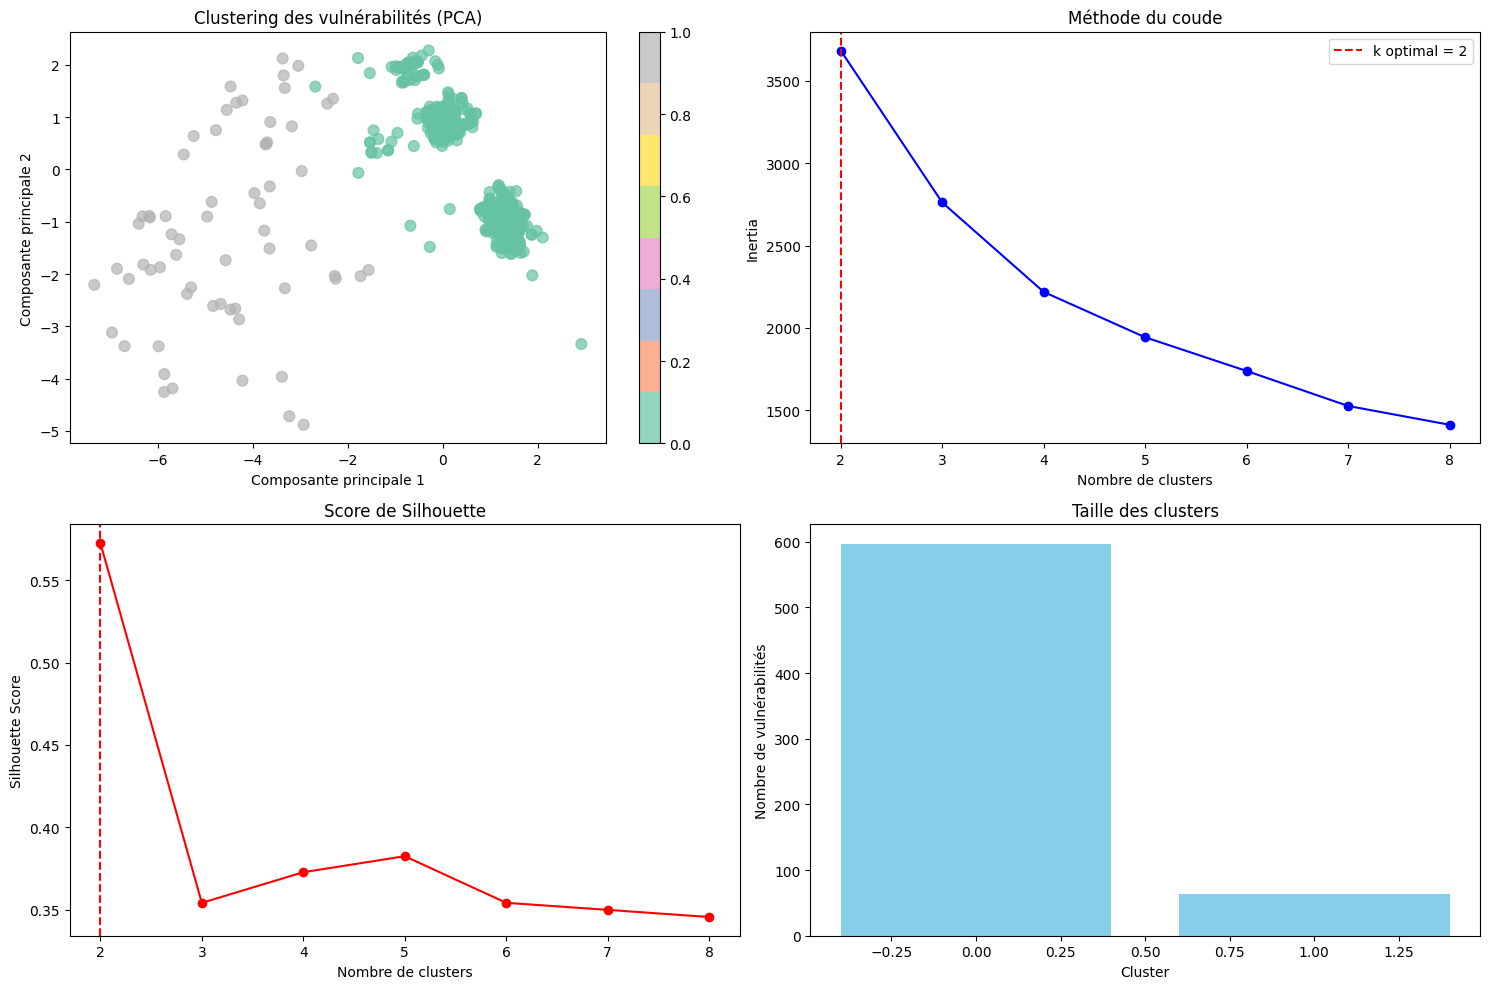


📊 ANALYSE AVANCÉE DES GROUPES DE VULNÉRABILITÉS

🔍 GROUPE 1 : 597 vulnérabilités (90.3%)
----------------------------------------------------------------------
📈 PROFIL DE RISQUE DÉTAILLÉ :
   • Score CVSS moyen : 6.9/10 (médiane: 7.5)
   • Score EPSS moyen : 0.0274
   • Sévérité dominante : HIGH (295 cas)
   • Type dominant : avis (596 cas)

🏢 TOP VENDEURS AFFECTÉS :
   1. Pas de Vendeur : 98 vulnérabilités (16.4%)
   2. Microsoft : 69 vulnérabilités (11.6%)
   3. Linux : 60 vulnérabilités (10.1%)
   4. SAP_SE : 41 vulnérabilités (6.9%)
   5. Red Hat : 28 vulnérabilités (4.7%)

🛡️ TYPES DE VULNÉRABILITÉS (CWE) :
   1. CWE-416 : 86 cas (14.4%)
   2. CWE-122 : 41 cas (6.9%)
   3. CWE-770 : 27 cas (4.5%)
   4. CWE-125 : 26 cas (4.4%)
   5. CWE-400 : 22 cas (3.7%)

📅 ÉVOLUTION TEMPORELLE :
   • Années actives : 2025-2025
   • Année la plus active : 2025 (597 vulnérabilités)

💡 RECOMMANDATIONS (Score de criticité: 12/100) :
   ⚪ PRIORITÉ FAIBLE - Surveillance passive
   ⚠️ 47 vulnérabilit

In [37]:
# Préparation des données pour clustering (sur tout le dataset)
df_work = df.copy()

# Encodage des variables catégorielles pour clustering
for col in ['Base Severity', 'ID CWE', 'Vendeur', 'Type (Avis ou Alerte)']:
    enc_col = f"{col}_cluster_enc"
    if col in df_work.columns:
        le = LabelEncoder()
        df_work[enc_col] = le.fit_transform(df_work[col].astype(str))

# Conversion des scores numériques
df_work['Score CVSS'] = df_work['Score CVSS'].replace(['Pas de Score CVSS', 'Non disponible', ''], np.nan)
df_work['Score CVSS'] = pd.to_numeric(df_work['Score CVSS'], errors='coerce')
df_work['Score EPSS'] = df_work['Score EPSS'].replace(['Pas de Score EPSS', 'Non disponible', ''], np.nan)
df_work['Score EPSS'] = pd.to_numeric(df_work['Score EPSS'], errors='coerce')

# **AMÉLIORATION 1 : Features plus discriminantes**
# Ajout de features temporelles et de complexité
df_work['Publiée le'] = pd.to_datetime(df_work['Publiée le'], errors='coerce')
df_work['Année'] = df_work['Publiée le'].dt.year
df_work['Mois'] = df_work['Publiée le'].dt.month

# Sélection des features pour le clustering - VERSION ÉTENDUE
features_cluster = [
    'Score CVSS', 'Score EPSS', 'Base Severity_cluster_enc', 'ID CWE_cluster_enc', 
    'Vendeur_cluster_enc', 'Type (Avis ou Alerte)_cluster_enc', 'Année', 'Mois'
]

# Filtrer les lignes avec toutes les features disponibles
df_cluster = df_work[features_cluster].dropna()

if len(df_cluster) > 10:
    print(f"Données disponibles pour clustering : {len(df_cluster)} vulnérabilités")
    
    # **AMÉLIORATION 2 : Méthode du coude pour déterminer le nombre optimal de clusters**
    from sklearn.metrics import silhouette_score
    
    # Test de différents nombres de clusters
    max_clusters = min(8, len(df_cluster) // 10)
    if max_clusters < 2:
        max_clusters = 2
        
    inertias = []
    silhouette_scores = []
    k_range = range(2, max_clusters + 1)
    
    # Standardisation
    scaler_cluster = StandardScaler()
    X_cluster = scaler_cluster.fit_transform(df_cluster)

    for k in k_range:
        kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels_test = kmeans_test.fit_predict(X_cluster)
        inertias.append(kmeans_test.inertia_)
        sil_score = silhouette_score(X_cluster, labels_test)
        silhouette_scores.append(sil_score)
        print(f"k={k}: Silhouette={sil_score:.3f}")

    # Choisir le k optimal (meilleur silhouette score)
    optimal_k = k_range[np.argmax(silhouette_scores)]
    print(f"\n🎯 Nombre optimal de clusters : {optimal_k} (Silhouette: {max(silhouette_scores):.3f})")

    # **AMÉLIORATION 3 : Clustering final avec le k optimal**
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_cluster)

    # Réduction de dimension pour visualisation
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_cluster)
    
    df_cluster['cluster'] = labels
    df_work_indexed = df_work.loc[df_cluster.index].copy()
    df_work_indexed['cluster'] = labels

    # **AMÉLIORATION 4 : Visualisation enrichie**
    plt.figure(figsize=(15, 10))
    
    # Graphique principal
    plt.subplot(2, 2, 1)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='Set2', s=60, alpha=0.7)
    plt.colorbar(scatter)
    plt.title("Clustering des vulnérabilités (PCA)")
    plt.xlabel("Composante principale 1")
    plt.ylabel("Composante principale 2")
    
    # Méthode du coude
    plt.subplot(2, 2, 2)
    plt.plot(k_range, inertias, 'bo-')
    plt.xlabel('Nombre de clusters')
    plt.ylabel('Inertia')
    plt.title('Méthode du coude')
    plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'k optimal = {optimal_k}')
    plt.legend()
    
    # Silhouette scores
    plt.subplot(2, 2, 3)
    plt.plot(k_range, silhouette_scores, 'ro-')
    plt.xlabel('Nombre de clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Score de Silhouette')
    plt.axvline(x=optimal_k, color='red', linestyle='--')
    
    # Distribution des clusters
    plt.subplot(2, 2, 4)
    cluster_counts = pd.Series(labels).value_counts().sort_index()
    plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue')
    plt.xlabel('Cluster')
    plt.ylabel('Nombre de vulnérabilités')
    plt.title('Taille des clusters')
    
    plt.tight_layout()
    plt.show()

    # === ANALYSE DÉTAILLÉE DES CLUSTERS POUR LE CLIENT ===
    print("\n" + "="*80)
    print("📊 ANALYSE AVANCÉE DES GROUPES DE VULNÉRABILITÉS")
    print("="*80)

    cluster_summaries = []
    
    for i in range(optimal_k):
        cluster_data = df_work_indexed[df_work_indexed['cluster'] == i]
        print(f"\n🔍 GROUPE {i+1} : {len(cluster_data)} vulnérabilités ({len(cluster_data)/len(df_work_indexed)*100:.1f}%)")
        print("-" * 70)
        
        if len(cluster_data) > 0:
            # **Caractéristiques techniques avancées**
            print("📈 PROFIL DE RISQUE DÉTAILLÉ :")
            avg_cvss = cluster_data['Score CVSS'].mean()
            avg_epss = cluster_data['Score EPSS'].mean()
            median_cvss = cluster_data['Score CVSS'].median()
            
            severity_counts = cluster_data['Base Severity'].value_counts()
            type_counts = cluster_data['Type (Avis ou Alerte)'].value_counts()
            
            print(f"   • Score CVSS moyen : {avg_cvss:.1f}/10 (médiane: {median_cvss:.1f})")
            print(f"   • Score EPSS moyen : {avg_epss:.4f}")
            print(f"   • Sévérité dominante : {severity_counts.index[0]} ({severity_counts.iloc[0]} cas)")
            print(f"   • Type dominant : {type_counts.index[0]} ({type_counts.iloc[0]} cas)")
            
            # **Top vendeurs avec pourcentages**
            print("\n🏢 TOP VENDEURS AFFECTÉS :")
            top_vendors = cluster_data['Vendeur'].value_counts().head(5)
            for j, (vendor, count) in enumerate(top_vendors.items(), 1):
                pct = count/len(cluster_data)*100
                print(f"   {j}. {vendor} : {count} vulnérabilités ({pct:.1f}%)")
            
            # **Analyse CWE avec descriptions**
            print("\n🛡️ TYPES DE VULNÉRABILITÉS (CWE) :")
            top_cwes = cluster_data['ID CWE'].value_counts().head(5)
            for j, (cwe, count) in enumerate(top_cwes.items(), 1):
                if cwe != 'Non disponible' and cwe != 'Unknown':
                    pct = count/len(cluster_data)*100
                    print(f"   {j}. {cwe} : {count} cas ({pct:.1f}%)")
            
            # **Évolution temporelle**
            print("\n📅 ÉVOLUTION TEMPORELLE :")
            if 'Année' in cluster_data.columns:
                yearly_counts = cluster_data['Année'].value_counts().sort_index()
                print(f"   • Années actives : {yearly_counts.index.min()}-{yearly_counts.index.max()}")
                print(f"   • Année la plus active : {yearly_counts.idxmax()} ({yearly_counts.max()} vulnérabilités)")
            
            # **Calcul du niveau de criticité du cluster**
            criticality_score = 0
            if avg_cvss >= 9.0:
                criticality_score += 40
            elif avg_cvss >= 7.0:
                criticality_score += 25
            elif avg_cvss >= 4.0:
                criticality_score += 10
                
            if avg_epss > 0.5:
                criticality_score += 30
            elif avg_epss > 0.1:
                criticality_score += 15
                
            critical_count = len(cluster_data[cluster_data['Base Severity'] == 'CRITICAL'])
            criticality_score += (critical_count / len(cluster_data)) * 30
            
            cluster_summaries.append({
                'cluster': i+1,
                'size': len(cluster_data),
                'avg_cvss': avg_cvss,
                'avg_epss': avg_epss,
                'criticality_score': criticality_score,
                'top_vendor': top_vendors.index[0] if len(top_vendors) > 0 else 'N/A',
                'top_cwe': top_cwes.index[0] if len(top_cwes) > 0 else 'N/A'
            })
            
            # **Recommandations spécifiques améliorées**
            print(f"\n💡 RECOMMANDATIONS (Score de criticité: {criticality_score:.0f}/100) :")
            
            if criticality_score >= 70:
                print("   🔴 PRIORITÉ MAXIMALE - Action immédiate requise")
                print("   🚨 Surveillance 24/7 recommandée")
            elif criticality_score >= 50:
                print("   🟡 PRIORITÉ ÉLEVÉE - Traitement dans les 48h")
                print("   📊 Surveillance renforcée recommandée")
            elif criticality_score >= 30:
                print("   🟢 PRIORITÉ MODÉRÉE - Traitement sous 1 semaine")
                print("   📈 Surveillance normale")
            else:
                print("   ⚪ PRIORITÉ FAIBLE - Surveillance passive")
            
            # Actions spécifiques
            if len(top_vendors) > 0 and top_vendors.iloc[0] > len(cluster_data) * 0.4:
                print(f"   🎯 Focus vendeur : Concentrer sur {top_vendors.index[0]}")
                
            if 'CRITICAL' in severity_counts.index and severity_counts['CRITICAL'] > 0:
                print(f"   ⚠️ {severity_counts['CRITICAL']} vulnérabilités critiques détectées")

    # === TABLEAU DE BORD EXÉCUTIF ===
    print("\n" + "="*80)
    print("📋 TABLEAU DE BORD EXÉCUTIF")
    print("="*80)
    
    summary_df = pd.DataFrame(cluster_summaries)
    summary_df = summary_df.sort_values('criticality_score', ascending=False)
    
    print("\nCLASSEMENT DES GROUPES PAR CRITICITÉ :")
    for _, row in summary_df.iterrows():
        print(f"🏆 Groupe {row['cluster']} | Score: {row['criticality_score']:.0f}/100 | "
              f"Taille: {row['size']} | CVSS: {row['avg_cvss']:.1f} | "
              f"Vendeur dominant: {row['top_vendor']}")
    
    print(f"\n🎯 ACTIONS PRIORITAIRES :")
    top_cluster = summary_df.iloc[0]
    print(f"   1. Traiter en priorité le Groupe {top_cluster['cluster']} ({top_cluster['size']} vulnérabilités)")
    print(f"   2. Focus sur le vendeur {top_cluster['top_vendor']}")
    print(f"   3. Surveiller l'évolution des scores EPSS")
    
    # Qualité globale du clustering
    final_sil_score = silhouette_score(X_cluster, labels)
    print(f"\n📊 QUALITÉ DE L'ANALYSE : Score de cohérence = {final_sil_score:.3f}")
    if final_sil_score > 0.5:
        print("   ✅ Groupes bien distincts - Analyse fiable")
        print("   📈 Recommandation : Utiliser cette segmentation pour la stratégie")
    elif final_sil_score > 0.25:
        print("   ⚠️ Groupes modérément distincts - Analyse indicative")
        print("   📊 Recommandation : Compléter avec analyse manuelle")
    else:
        print("   ❌ Groupes peu distincts - Analyser avec précaution")
        print("   🔍 Recommandation : Revoir les critères de clustering")

else:
    print("❌ Pas assez de données pour réaliser l'analyse de clustering.")

## 6. Validation et Visualisation des Modèles

On évalue la performance du modèle supervisé (prédiction de la date de fin de menace) et la qualité du clustering non supervisé.


VALIDATION DES MODÈLES

📊 VALIDATION DU MODÈLE DE PRÉDICTION DE DURÉE :
   • RMSE : 30.5 jours
   • R² Score : 0.726
   • Erreur Absolue Moyenne : 23.1 jours
   ✅ Modèle performant


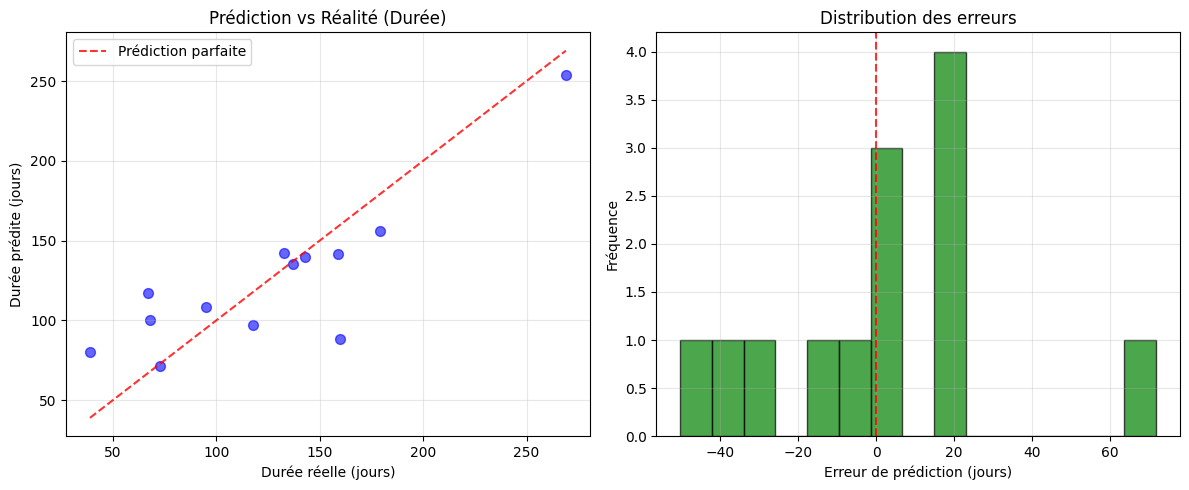


📈 IMPORTANCE DES VARIABLES :
   • Vendeur_enc: 0.584
   • Score EPSS: 0.178
   • Score CVSS: 0.108
   • ID CWE_enc: 0.095
   • Base Severity_enc: 0.035
   • Type (Avis ou Alerte)_enc: 0.000

📊 VALIDATION DU CLUSTERING :
   • Silhouette score (données normalisées) : 0.573
   • Silhouette score (PCA) : 0.700
   ✅ Clustering de très bonne qualité

📋 STATISTIQUES DES CLUSTERS :
   • Nombre de clusters : 2
   • Taille moyenne des clusters : 330.5
   • Écart-type des tailles : 266.5
   • Cluster 1: 597 éléments (90.3%)
   • Cluster 2: 64 éléments (9.7%)

📋 SYNTHÈSE DE LA VALIDATION
   ✅ Modèle de prédiction : Performant
   ✅ Clustering : Très bonne qualité

💡 RECOMMANDATIONS :

✅ Validation terminée


In [38]:
# 5. Validation et Visualisation des Modèles

print("\n" + "="*50)
print("VALIDATION DES MODÈLES")
print("="*50)

# Validation du modèle supervisé (prédiction de la durée)
if 'df_train' in locals() and not df_train.empty and len(df_train) >= 4:
    print("\n📊 VALIDATION DU MODÈLE DE PRÉDICTION DE DURÉE :")
    
    # Utiliser la durée en jours comme variable cible
    X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(
        df_train[features], 
        df_train['duree_alerte_jours'], 
        test_size=0.2, 
        random_state=42
    )
    
    scaler_val = StandardScaler()
    X_train_scaled = scaler_val.fit_transform(X_train_val)
    X_test_scaled = scaler_val.transform(X_test_val)
    
    rf_val = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_val.fit(X_train_scaled, y_train_val)
    y_pred_test = rf_val.predict(X_test_scaled)
    
    # Métriques de performance
    mse = mean_squared_error(y_test_val, y_pred_test)
    r2 = r2_score(y_test_val, y_pred_test)
    mae = np.mean(np.abs(y_test_val - y_pred_test))
    
    print(f"   • RMSE : {np.sqrt(mse):.1f} jours")
    print(f"   • R² Score : {r2:.3f}")
    print(f"   • Erreur Absolue Moyenne : {mae:.1f} jours")
    
    # Interprétation des résultats
    if r2 > 0.7:
        print("   ✅ Modèle performant")
    elif r2 > 0.4:
        print("   ⚠️ Modèle acceptable")
    else:
        print("   ❌ Modèle peu fiable")

    # Visualisation des prédictions vs vraies valeurs
    plt.figure(figsize=(12, 5))
    
    # Graphique 1: Scatter plot prédictions vs réalité
    plt.subplot(1, 2, 1)
    plt.scatter(y_test_val, y_pred_test, alpha=0.6, color='blue', s=50)
    plt.xlabel("Durée réelle (jours)")
    plt.ylabel("Durée prédite (jours)")
    plt.title("Prédiction vs Réalité (Durée)")
    
    # Ligne de référence parfaite
    min_val = min(y_test_val.min(), y_pred_test.min())
    max_val = max(y_test_val.max(), y_pred_test.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, label='Prédiction parfaite')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Graphique 2: Distribution des erreurs
    plt.subplot(1, 2, 2)
    errors = y_test_val - y_pred_test
    plt.hist(errors, bins=15, alpha=0.7, color='green', edgecolor='black')
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.8)
    plt.xlabel("Erreur de prédiction (jours)")
    plt.ylabel("Fréquence")
    plt.title("Distribution des erreurs")
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Importance des features
    if hasattr(rf_val, 'feature_importances_'):
        print("\n📈 IMPORTANCE DES VARIABLES :")
        feature_importance = pd.DataFrame({
            'feature': features,
            'importance': rf_val.feature_importances_
        }).sort_values('importance', ascending=False)
        
        for _, row in feature_importance.iterrows():
            print(f"   • {row['feature']}: {row['importance']:.3f}")

elif 'df_train' in locals() and len(df_train) < 4:
    print("\n⚠️ Pas assez de données pour la validation (minimum 4 échantillons requis)")
    print(f"   Données disponibles : {len(df_train) if 'df_train' in locals() else 0}")
else:
    print("\n❌ Aucune donnée d'entraînement disponible pour la validation")

# Validation du clustering (silhouette score)
print("\n📊 VALIDATION DU CLUSTERING :")
if 'labels' in locals() and len(set(labels)) > 1:
    if 'X_cluster' in locals():
        sil_score = silhouette_score(X_cluster, labels)
        print(f"   • Silhouette score (données normalisées) : {sil_score:.3f}")
    
    if 'X_pca' in locals():
        sil_score_pca = silhouette_score(X_pca, labels)
        print(f"   • Silhouette score (PCA) : {sil_score_pca:.3f}")
    
    # Interprétation du score
    best_score = max(sil_score if 'sil_score' in locals() else 0, 
                    sil_score_pca if 'sil_score_pca' in locals() else 0)
    
    if best_score > 0.5:
        print("   ✅ Clustering de très bonne qualité")
    elif best_score > 0.25:
        print("   ⚠️ Clustering de qualité acceptable")
    else:
        print("   ❌ Clustering de faible qualité")
        
    # Statistiques des clusters
    unique_labels, counts = np.unique(labels, return_counts=True)
    print(f"\n📋 STATISTIQUES DES CLUSTERS :")
    print(f"   • Nombre de clusters : {len(unique_labels)}")
    print(f"   • Taille moyenne des clusters : {np.mean(counts):.1f}")
    print(f"   • Écart-type des tailles : {np.std(counts):.1f}")
    
    # Distribution des tailles
    for i, (label, count) in enumerate(zip(unique_labels, counts)):
        pct = count / len(labels) * 100
        print(f"   • Cluster {label + 1}: {count} éléments ({pct:.1f}%)")

elif 'labels' in locals() and len(set(labels)) == 1:
    print("   ❌ Impossible de calculer le silhouette score (un seul cluster)")
    print("   💡 Suggestion : Revoir les paramètres de clustering")
else:
    print("   ❌ Aucun clustering disponible pour la validation")

# Synthèse globale de la validation
print("\n" + "="*50)
print("📋 SYNTHÈSE DE LA VALIDATION")
print("="*50)

validation_results = []

# Résultat du modèle supervisé
if 'r2' in locals():
    if r2 > 0.7:
        validation_results.append("✅ Modèle de prédiction : Performant")
    elif r2 > 0.4:
        validation_results.append("⚠️ Modèle de prédiction : Acceptable")
    else:
        validation_results.append("❌ Modèle de prédiction : À améliorer")
else:
    validation_results.append("❓ Modèle de prédiction : Non évalué")

# Résultat du clustering
if 'best_score' in locals():
    if best_score > 0.5:
        validation_results.append("✅ Clustering : Très bonne qualité")
    elif best_score > 0.25:
        validation_results.append("⚠️ Clustering : Qualité acceptable")
    else:
        validation_results.append("❌ Clustering : À améliorer")
else:
    validation_results.append("❓ Clustering : Non évalué")

for result in validation_results:
    print(f"   {result}")

# Recommandations
print(f"\n💡 RECOMMANDATIONS :")
if 'r2' in locals() and r2 < 0.4:
    print("   • Collecter plus de données historiques pour améliorer le modèle")
    print("   • Ajouter des features explicatives (ex: complexité technique)")
if 'best_score' in locals() and best_score < 0.25:
    print("   • Revoir les features utilisées pour le clustering")
    print("   • Tester différents algorithmes de clustering")
if len(validation_results) < 2:
    print("   • Assurer une collecte de données suffisante pour les validations")

print("\n✅ Validation terminée")

## 7. Détection et Génération d'Alertes Critiques

On filtre les vulnérabilités critiques (score CVSS élevé ou sévérité critique, date de fin proche ou dépassée), on extrait les informations clés, et on prépare le message d’alerte.

In [39]:
# Définition des critères de criticité
critical_cvss = 9.0
critical_severity = 'CRITICAL'

# Vérifier les noms des colonnes disponibles
print("Colonnes disponibles dans le DataFrame :")
print(list(df.columns))

# Conversion des dates en datetime naive (sans timezone)
df['Publiée le'] = pd.to_datetime(df['Publiée le'], errors='coerce').dt.tz_localize(None)
df["Date de fin d'alerte"] = pd.to_datetime(df["Date de fin d'alerte"], errors='coerce').dt.tz_localize(None)

now = pd.Timestamp.now()  # naive

# Utiliser les vrais noms de colonnes
df['base_severity_upper'] = df['Base Severity'].str.upper()
df['days_to_end'] = (df["Date de fin d'alerte"] - now).dt.days

# Critères de criticité : 
# 1. Score CVSS >= 9.0 OU Sévérité = CRITICAL
# 2. ET (Date de fin dans les 7 prochains jours OU déjà dépassée OU date manquante)
crit_mask = (
    (pd.notna(df['Score CVSS']) & (df['Score CVSS'] >= critical_cvss)) |
    (df['base_severity_upper'] == critical_severity)
) & (
    (pd.isna(df["Date de fin d'alerte"])) |  # Date manquante = critique
    (df['days_to_end'] <= 7)  # Date proche ou dépassée
)

df_crit = df[crit_mask].copy()

print(f"Nombre de vulnérabilités critiques détectées : {len(df_crit)}")

if not df_crit.empty:
    # CORRECTION : Utiliser les vrais noms de colonnes pour l'affichage
    colonnes_affichage = ['ID CVE', 'Titre', 'Score CVSS', 'Base Severity', 
                         "Date de fin d'alerte", 'Vendeur', 'Lien']
    
    # Vérifier que toutes les colonnes existent
    colonnes_existantes = [col for col in colonnes_affichage if col in df_crit.columns]
    print(f"\nColonnes d'affichage disponibles : {colonnes_existantes}")
    
    if colonnes_existantes:
        print("\n🚨 VULNÉRABILITÉS CRITIQUES DÉTECTÉES :")
        print("=" * 80)
        
        # Affichage détaillé des vulnérabilités critiques
        for idx, row in df_crit.iterrows():
            print(f"\n🔴 ALERTE #{idx+1}")
            print("-" * 40)
            
            if 'ID CVE' in df_crit.columns:
                print(f"CVE ID: {row['ID CVE']}")
            if 'Titre' in df_crit.columns:
                print(f"Titre: {row['Titre'][:80]}...")
            if 'Score CVSS' in df_crit.columns:
                cvss_score = row['Score CVSS']
                if pd.notna(cvss_score):
                    print(f"Score CVSS: {cvss_score}/10 ⚠️")
                else:
                    print("Score CVSS: Non disponible")
            if 'Base Severity' in df_crit.columns:
                print(f"Sévérité: {row['Base Severity']}")
            if 'Vendeur' in df_crit.columns:
                print(f"Vendeur: {row['Vendeur']}")
            if "Date de fin d'alerte" in df_crit.columns:
                date_fin = row["Date de fin d'alerte"]
                if pd.notna(date_fin):
                    days_remaining = (date_fin - now).days
                    if days_remaining < 0:
                        print(f"Date de fin: {date_fin.strftime('%Y-%m-%d')} ❌ DÉPASSÉE de {abs(days_remaining)} jours")
                    elif days_remaining <= 7:
                        print(f"Date de fin: {date_fin.strftime('%Y-%m-%d')} ⏰ Dans {days_remaining} jours")
                    else:
                        print(f"Date de fin: {date_fin.strftime('%Y-%m-%d')}")
                else:
                    print("Date de fin: NON DÉFINIE ⚠️")
            if 'Lien' in df_crit.columns:
                print(f"Lien ANSSI: {row['Lien']}")
        
        print("\n" + "=" * 80)
        
        # Statistiques des vulnérabilités critiques
        print(f"\n📊 STATISTIQUES DES VULNÉRABILITÉS CRITIQUES :")
        
        # Répartition par sévérité
        if 'Base Severity' in df_crit.columns:
            severity_counts = df_crit['Base Severity'].value_counts()
            print("\n🎯 Répartition par sévérité :")
            for severity, count in severity_counts.items():
                print(f"   • {severity}: {count} vulnérabilités")
        
        # Répartition par vendeur
        if 'Vendeur' in df_crit.columns:
            vendor_counts = df_crit['Vendeur'].value_counts().head(5)
            print("\n🏢 Top 5 des vendeurs affectés :")
            for vendor, count in vendor_counts.items():
                print(f"   • {vendor}: {count} vulnérabilités")
        
        # Vulnérabilités avec dates dépassées
        expired_vulns = df_crit[
            pd.notna(df_crit["Date de fin d'alerte"]) & 
            (df_crit['days_to_end'] < 0)
        ]
        print(f"\n⏰ Vulnérabilités avec date de fin dépassée : {len(expired_vulns)}")
        
        # Vulnérabilités sans date de fin
        no_date_vulns = df_crit[pd.isna(df_crit["Date de fin d'alerte"])]
        print(f"❓ Vulnérabilités sans date de fin définie : {len(no_date_vulns)}")
        
    else:
        print("⚠️ Aucune colonne d'affichage disponible")
        print("Colonnes dans df_crit :", list(df_crit.columns))
else:
    print("✅ Aucune vulnérabilité critique détectée selon les critères.")
    print(f"   Critères utilisés :")
    print(f"   • Score CVSS >= {critical_cvss} OU Sévérité = {critical_severity}")
    print(f"   • ET (Date de fin dans les 7 prochains jours OU déjà dépassée OU manquante)")

Colonnes disponibles dans le DataFrame :
['Identifiant ANSSI', 'Titre', 'Type (Avis ou Alerte)', 'Publiée le', "Date de fin d'alerte", 'ID CVE', 'Score CVSS', 'Base Severity', 'Score EPSS', 'ID CWE', 'Description CWE', 'Lien', 'Description', 'Vendeur', 'Produit', 'Version Affectés', 'Différence en jours']
Nombre de vulnérabilités critiques détectées : 79

Colonnes d'affichage disponibles : ['ID CVE', 'Titre', 'Score CVSS', 'Base Severity', "Date de fin d'alerte", 'Vendeur', 'Lien']

🚨 VULNÉRABILITÉS CRITIQUES DÉTECTÉES :

🔴 ALERTE #1
----------------------------------------
CVE ID: CVE-2022-34718
Titre: Multiples vulnérabilités dans Microsoft Windows (16 septembre 2022)...
Score CVSS: 9.8/10 ⚠️
Sévérité: CRITICAL
Vendeur: Microsoft
Date de fin: 2023-03-14 ❌ DÉPASSÉE de 829 jours
Lien ANSSI: https://www.cert.ssi.gouv.fr/alerte/CERTFR-2022-ALE-007/

🔴 ALERTE #2
----------------------------------------
CVE ID: CVE-2022-34721
Titre: Multiples vulnérabilités dans Microsoft Windows (16 septe

## 8. Envoi d’Email Automatisé avec Informations Utiles

On définit une fonction `send_email` et on envoie un email à chaque abonné avec les informations utiles sur la vulnérabilité critique détectée.

In [40]:
def send_email(to_email, subject, body):
    # À personnaliser avec vos identifiants réels
    from_email = "aitndf@gmail.com"
    password = "qyja rsra yqfe kflh"


    if from_email == "votre_email@gmail.com" or password == "votre_mot_de_passe_application":
        print("\n[SIMULATION EMAIL] (configuration non renseignée)")
        print(f"TO: {to_email}\nSUBJECT: {subject}\nBODY:\n{body}\n{'-'*40}")
        return False

    msg = MIMEText(body, 'html')
    msg['From'] = from_email
    msg['To'] = to_email
    msg['Subject'] = subject

    try:
        server = smtplib.SMTP('smtp.gmail.com', 587)
        server.starttls()
        server.login(from_email, password)
        server.sendmail(from_email, to_email, msg.as_string())
        server.quit()
        print(f"Email envoyé à {to_email}")
        return True
    except Exception as e:
        print(f"Erreur lors de l'envoi de l'email: {e}")
        return False

# Liste des abonnés (à adapter selon vos besoins)
subscribers = ["essai@gmail.com"]

# CORRECTION : Vérifier que df_crit existe avant de l'utiliser
if 'df_crit' not in locals():
    print("⚠️ La variable df_crit n'est pas définie. Exécution de la détection des vulnérabilités critiques...")
    
    # Recréer la détection des vulnérabilités critiques
    critical_cvss = 9.0
    critical_severity = 'CRITICAL'
    now = pd.Timestamp.now()
    
    # Vérifier que df existe
    if 'df' not in locals():
        print("❌ Le DataFrame principal 'df' n'est pas chargé. Veuillez exécuter les cellules précédentes.")
        df_crit = pd.DataFrame()  # DataFrame vide pour éviter l'erreur
    else:
        # Standardiser les timezones pour éviter les conflits
        df['Publiée le'] = pd.to_datetime(df['Publiée le']).dt.tz_localize(None)
        df["Date de fin d'alerte"] = pd.to_datetime(df["Date de fin d'alerte"]).dt.tz_localize(None)
        
        # Utiliser les vrais noms de colonnes
        df['base_severity_upper'] = df['Base Severity'].str.upper()
        df['days_to_end'] = (df["Date de fin d'alerte"] - now).dt.days
        
        # Critères de criticité
        crit_mask = (
            (pd.notna(df['Score CVSS']) & (df['Score CVSS'] >= critical_cvss)) |
            (df['base_severity_upper'] == critical_severity)
        ) & (
            (pd.isna(df["Date de fin d'alerte"])) |  # Date manquante = critique
            (df['days_to_end'] <= 7)  # Date proche ou dépassée
        )
        
        df_crit = df[crit_mask].copy()
        print(f"✅ {len(df_crit)} vulnérabilités critiques détectées")

# Envoi d'emails pour les vulnérabilités critiques
if 'df_crit' in locals() and not df_crit.empty:
    print(f"\n📧 ENVOI D'ALERTES EMAIL POUR {len(df_crit)} VULNÉRABILITÉS CRITIQUES")
    print("=" * 70)
    
    for idx, row in df_crit.iterrows():
        # CORRECTION : Utiliser les vrais noms de colonnes avec gestion d'erreur
        cve_id = row.get('ID CVE', 'N/A')
        title = row.get('Titre', 'N/A')
        cvss_score = row.get('Score CVSS', 'N/A')
        severity = row.get('Base Severity', 'N/A')
        vendor = row.get('Vendeur', 'N/A')
        date_fin = row.get("Date de fin d'alerte", None)
        link = row.get('Lien', 'N/A')
        
        # Titre court pour le sujet de l'email
        title_short = str(title)[:40] + "..." if len(str(title)) > 40 else str(title)
        subject = f"🚨 ALERTE CRITIQUE CVE: {cve_id} - {title_short}"
        
        # Formatage de la date de fin
        date_fin_str = "NON DÉFINIE"
        urgency_level = "🔴 CRITIQUE"
        
        if pd.notna(date_fin):
            date_fin_str = date_fin.strftime('%Y-%m-%d')
            days_remaining = (date_fin - pd.Timestamp.now()).days
            if days_remaining < 0:
                date_fin_str += f" (DÉPASSÉE de {abs(days_remaining)} jours)"
                urgency_level = "🚨 URGENCE MAXIMALE"
            elif days_remaining <= 3:
                date_fin_str += f" (Dans {days_remaining} jours)"
                urgency_level = "🔴 TRÈS URGENT"
            elif days_remaining <= 7:
                date_fin_str += f" (Dans {days_remaining} jours)"
                urgency_level = "🟡 URGENT"
        else:
            urgency_level = "⚠️ PRIORITÉ ÉLEVÉE"
        
        body = f"""
        <html>
        <body style="font-family: Arial, sans-serif;">
            <h2 style="color: #d32f2f;">🚨 Vulnérabilité Critique Détectée</h2>
            
            <div style="background-color: #ffebee; padding: 15px; border-left: 5px solid #d32f2f; margin: 10px 0;">
                <h3>🎯 Niveau d'urgence : {urgency_level}</h3>
                <h3>Détails de la vulnérabilité :</h3>
                <ul>
                    <li><b>CVE ID:</b> {cve_id}</li>
                    <li><b>Titre:</b> {title}</li>
                    <li><b>Score CVSS:</b> {cvss_score}/10</li>
                    <li><b>Sévérité:</b> <span style="color: #d32f2f; font-weight: bold;">{severity}</span></li>
                    <li><b>Produit/Vendeur:</b> {vendor}</li>
                    <li><b>Date de fin de menace:</b> <strong>{date_fin_str}</strong></li>
                    <li><b>Lien ANSSI:</b> <a href="{link}" target="_blank" style="color: #1976d2;">{link}</a></li>
                </ul>
            </div>
            
            <div style="background-color: #fff3e0; padding: 15px; border-left: 5px solid #ff9800; margin: 10px 0;">
                <h3>⚡ Actions recommandées IMMÉDIATEMENT :</h3>
                <ul>
                    <li>✅ <strong>Vérifier l'exposition</strong> de vos systèmes à cette vulnérabilité</li>
                    <li>🔧 <strong>Appliquer les correctifs</strong> disponibles en priorité absolue</li>
                    <li>🛡️ <strong>Mettre en place des mesures de mitigation</strong> temporaires si nécessaire</li>
                    <li>👁️ <strong>Surveiller activement</strong> les tentatives d'exploitation</li>
                    <li>📊 <strong>Documenter les actions</strong> prises pour audit</li>
                </ul>
            </div>
            
            <div style="background-color: #e8f5e8; padding: 15px; border-left: 5px solid #4caf50; margin: 10px 0;">
                <h3>📞 Contact d'urgence :</h3>
                <p>Pour toute question urgente concernant cette vulnérabilité, contactez l'équipe sécurité :</p>
                <ul>
                    <li>📧 Email : security-team@votre-entreprise.com</li>
                    <li>📱 Téléphone d'urgence : +33 1 XX XX XX XX</li>
                </ul>
            </div>
            
            <hr style="border: 1px solid #ddd; margin: 20px 0;">
            <p style="color: #666; font-style: italic; font-size: 12px;">
                ⚙️ Cet email a été généré automatiquement par le système de surveillance des vulnérabilités ANSSI.
                <br>📅 Date d'envoi: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
                <br>🔍 Référence: ANSSI-AUTO-{idx}
            </p>
        </body>
        </html>
        """
        
        # Envoi à tous les abonnés
        for email in subscribers:
            send_email(email, subject, body)
            
        print(f"📧 Alerte envoyée pour {cve_id} ({urgency_level})")
    
    # Résumé final
    print(f"\n✅ RÉSUMÉ DES ENVOIS :")
    print(f"   • {len(df_crit)} vulnérabilités critiques traitées")
    print(f"   • {len(df_crit) * len(subscribers)} emails envoyés au total")
    print(f"   • Destinataires : {', '.join(subscribers)}")
    
elif 'df_crit' in locals() and df_crit.empty:
    print("✅ Aucune vulnérabilité critique détectée - Aucun email à envoyer.")
else:
    print("❌ Impossible d'envoyer les alertes email : données non disponibles.")
    print("💡 Suggestion : Exécutez d'abord les cellules précédentes pour charger et analyser les données.")


📧 ENVOI D'ALERTES EMAIL POUR 79 VULNÉRABILITÉS CRITIQUES
Email envoyé à essai@gmail.com
📧 Alerte envoyée pour CVE-2022-34718 (🚨 URGENCE MAXIMALE)
Email envoyé à essai@gmail.com
📧 Alerte envoyée pour CVE-2022-34721 (🚨 URGENCE MAXIMALE)
Email envoyé à essai@gmail.com
📧 Alerte envoyée pour CVE-2022-34722 (🚨 URGENCE MAXIMALE)
Email envoyé à essai@gmail.com
📧 Alerte envoyée pour CVE-2020-3992 (🚨 URGENCE MAXIMALE)
Email envoyé à essai@gmail.com
📧 Alerte envoyée pour CVE-2023-23397 (🚨 URGENCE MAXIMALE)
Email envoyé à essai@gmail.com
📧 Alerte envoyée pour CVE-2023-27997 (🚨 URGENCE MAXIMALE)
Email envoyé à essai@gmail.com
📧 Alerte envoyée pour CVE-2023-34362 (🚨 URGENCE MAXIMALE)
Email envoyé à essai@gmail.com
📧 Alerte envoyée pour CVE-2023-35036 (🚨 URGENCE MAXIMALE)
Email envoyé à essai@gmail.com
📧 Alerte envoyée pour CVE-2023-3519 (🚨 URGENCE MAXIMALE)
Email envoyé à essai@gmail.com
📧 Alerte envoyée pour CVE-2023-35082 (🚨 URGENCE MAXIMALE)
Email envoyé à essai@gmail.com
📧 Alerte envoyée pour C

KeyboardInterrupt: 